# Multidimensional Knapsack Problem

Integrantes:

*   Joseph Donoso Carvacho 21.067.120-K
*   Felipe Zepeda Cofre 20.781.030-4



## Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rand
import copy
import statsmodels.api as sm
from enum import Enum
from functools import partial
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Utilidades

In [2]:
class File:
  """
  Una clase implementada para facilitar la lectura de
  tokens de un archivo de texto.
  """
  def __init__(self, text_file):
    """
    Inicializa un objeto de tipo File.

    Attributes:
      text_file (list): Una lista con los tokens de un archivo de texto.
      index_file (list): Un digíto indicador del token actual de lectura.
    """
    self.text_file = text_file
    self.index_file = [-1]

  def next_token(self) -> str:
    """
    Lee el siguiente token de la lista text_file.

    Returns:
      str: El siguiente token.
    """
    self.index_file[0] += 1
    return self.text_file[self.index_file[0]]

## Implementación

*   La implementación Greedy fue desarrollada e ideada en su totalidad por el grupo.
*   La implementación de la metaheurística Binary Genetic Algorithm está inspirada por recursos del aula.

In [3]:
class MKP:
  """
  Una clase implementada para modelar y resolver
  el Multidimensional Knapsack Problem.
  """
  def __init__(self):
    """
    Inicializa un objeto de tipo MKP.

    Attributes:
      instancia (list): Una instancia del problema que contiene
                        los objetos y restricciones del mismo.
      num_objects (int): La cantidad de objetos totales del problema.
      num_dimensions (int): La cantidad de dimensiones que tendrá el
                            peso de los objetos.
    """
    self.instance = []
    self.num_objects = int
    self.num_dimensions = int
    self.optimun_value = float

  def instance_generator(self,
                         range_obj = (4,80),
                         range_dim = (4,80),
                         range_weight_dim = (2,10),
                         range_value_obj = (8,15) ) -> None:
    """
    Genera una instancia randomizada del problema.

    Arguments:
      range_obj (tuple): El rango aleatorio de generación de objetos.
      range_dim (tuple): El rango aleatorio de generación de dimensiones.
      range_weight_dim (tuple): El rango aleatorio de generación
                                de pesos por cada dimensión.
      range_value_obj (tuple): El rango aleatorio de generación
                               de valores de los objetos.
    """
    self.instance = []
    self.num_objects = rand.randint(range_obj[0], range_obj[1])
    self.num_dimensions = rand.randint(range_dim[0], range_dim[1])
    self.optimun_value = 0
    #Genera los objetos del tamaño de sus dimensiones +1(su valor)
    for i in range(self.num_objects):
      objects = [0] * (self.num_dimensions + 1)
      #Genera un peso aleatorio para cada dimensión, además de su valor
      for j in range(self.num_dimensions):
        objects[j] = rand.randint(range_weight_dim[0],range_weight_dim[1])
      objects[-1] = rand.randint(range_value_obj[0], range_value_obj[1])
      #Añade cada objeto a la intancia del problema
      self.instance.append(objects)
    #Además de las restricciones de la mochila por cada dimensión
    self.instance.append(self.__restrictions_generator())

  def __max_profit_generator(self) -> float:
    """
    Calcula la máxima ganancia posible con la suma
    del valor de todos los objetos.

    Returns:
      value_max (str): La suma total.
    """
    value_max = 0
    for i in range(self.num_objects):
      value_max += self.instance[i][-1]
    return value_max

  def __restrictions_generator(self, range_rest = (40,10)) -> list:
    """
    Genera las restricciones de peso por dimensión de la mochila
    (su peso máximo en cada dimensión), además del máximo valor obtenible
    si se pudiesen llevar todos los objetos.

    Arguments:
      range_rest (tuple): El rango aleatorio de generación de los pesos
                          máximos de la mochila en cada dimensión
                          (está en base al máximo peso real de los objetos).

    Returns:
      restrictions (list): La lista de pesos máximo por cada dimensión
                           y el valor máximo.
    """
    restrictions = [0] * (self.num_dimensions)
    for i in range(self.num_dimensions):
      #Se obtiene un número aleatorio de restricción a partir
      #del máximo peso de los objetos por dimension +_ un rango de restriccion
      weight_max = 0
      for j in range(self.num_objects):
        weight_max += self.instance[j][i]
      restrictions[i] = rand.randint(weight_max - range_rest[0],
                                     weight_max + range_rest[1])
      if restrictions[i] <= 0:
        restrictions[i] = 10

    #Se agregará una última restricción en referencia
    #a la cantidad máxima de dinero que se puede obtener
    #(la suma del valor de todos los objetos)
    restrictions.append(self.__max_profit_generator())
    return restrictions

  def __validate_object(self, obj, rest) -> bool:
    """
    Recorre todas las dimensiones del objeto dado validando
    que cabe en la mochila en cada una de ellas.

    Arguments:
      obj (list): Representa un objeto en forma de lista de pesos.
      rest (list): Representa las restricciones de la mochila
                   como lista de pesos máximos.

    Returns:
      bool: True si el objeto cabe en la mochila, False en caso contrario.
    """
    #Se verifica el peso del objeto en todas las dimensiones
    for i in range(self.num_dimensions):
      if obj[i] > rest[i]:
        return False
    return True

  def print_instance(self):
    """
    Muestra por pantalla todos los objetos de la instancia con sus pesos
    y sus valores, además de las restricciones de la mochila.
    """
    for i in range(self.num_objects):
      print("Objeto", str(i+1)+":", self.instance[i])
    print("Restricciones:", self.instance[-1])
    print("Cantidad de objetos:", self.num_objects)
    print("Cantidad de dimensiones:", self.num_dimensions)

  def instance_loader(self, file: File):
    """
    Carga la instancia de un problema a partir de un archivo
    de texto en formato File (una clase implementada para ello).

    Arguments:
      file (File): Un objeto que contiene todos los tokens de la instancia
                   (se puede hacer uso de estos a partir de su función propia).
    """
    self.instance = []
    self.num_objects  = int(file.next_token())
    self.num_dimensions  = int(file.next_token())
    self.optimun_value  = float(file.next_token())

    #Genera los objetos del tamaño de sus dimensiones +1(su valor)
    for i in range(self.num_objects):
      objects = [0] * (self.num_dimensions + 1)
      #Añade cada objeto a la intancia del problema
      self.instance.append(objects)

    #Lectura del archivo
    for i in range(self.num_dimensions, -1, -1):
      for j in range(self.num_objects):
        self.instance[j][i]  = float(file.next_token())

    #Además de las restricciones de la mochila por cada dimensión
    restrictions = [0] * (self.num_dimensions)
    for i in range(self.num_dimensions-1, -1, -1):
      restrictions[i] = float(file.next_token())

    #Se agregará una última restricción en referencia
    #a la cantidad máxima de dinero que se puede obtener
    #(la suma del valor de todos los objetos)
    restrictions.append(self.__max_profit_generator())
    self.instance.append(restrictions)

  def evaluate_fitness(self, chromosome):
    """
    Calcula el valor de la solución para el actual cromosoma.

    Arguments:
      chromosome (list): Lista binaria de una solución al problema
                        (representa un individuo).
    Returns:
      fitness (float): El valor del cromosoma dado (0 si no es una
                       solución viable).
    """
    #Se evalúa si la solución es factible, en caso de que nó, se retorna 0
    for i in range(self.num_dimensions):
      total_weight = 0
      for j in range(self.num_objects):
        total_weight += chromosome[j] * self.instance[j][i]
      if total_weight > self.instance[-1][i]:
        return 0

    #Se evalua el valor de la solución
    fitness = 0
    for i in range(self.num_objects):
      fitness += chromosome[i] * self.instance[i][-1]

    return fitness

  def tournament_selection(population, fitnesses, k = 10):
    """
    Elige individuos (cromosomas) que participarán en la reproducción
    (cruce y mutación) para crear la siguiente generación. Este método simula
    un torneo entre un subconjunto de la población para
    seleccionar a los mejores individuos.

    Arguments:
      population (list): Lista de individuos (cromosomas) de una población.
      fitnesses (list): Lista del valor fitness para cada individuo.
      k (int): El tamaño de subconjunto de individuos que participará
              en el torneo.

    Returns:
      parent1 (list): El cromosoma del padre 1.
      parent2 (list): El cromosoma del padre 2.
    """
    #Se asegura que k sea menor al largo de la población
    if k > len(population):
      k = len(population) // 2

    #Se escoge el subconcunto para el primer padre
    participants = rand.sample(list(zip(population, fitnesses)), k)
    winner = max(participants, key=lambda x: x[1])
    parent1 = winner[0]

    #Se escoge el subconcunto para el segundo padre
    participants = rand.sample(list(zip(population, fitnesses)), k)
    winner = max(participants, key=lambda x: x[1])
    parent2 = winner[0]

    return parent1, parent2

  def roulette_wheel_selection(population, fitnesses):
    """
    Elige individuos (cromosomas) que participarán en la reproducción
    (cruce y mutación) para crear la siguiente generación. Este método asigna
    probabilidades de selección a cada individuo de acuerdo a su calidad.

    Arguments:
      population (list): Lista de individuos (cromosomas) de una población.
      fitnesses (list): Lista del valor fitness para cada individuo.

    Returns:
      parent1 (list): El cromosoma del padre 1.
      parent2 (list): El cromosoma del padre 2.
    """
    #Se calcula el total de aptitud de toda la población
    total_fitness = sum(fitnesses)
    #Si el total es igual a 0
    if total_fitness == 0:
      #Se seleccionan 2 padres aleatoriamente
      return rand.choices(population, k=2)

    #Se asignan probabilidades de selección a cada individuo
    selection_probs = [fitness / total_fitness for fitness in fitnesses]
    parent1 = rand.choices(population, weights=selection_probs, k=1)[0]
    parent2 = rand.choices(population, weights=selection_probs, k=1)[0]
    return parent1, parent2

  def uniform_crossover(parent1, parent2, prob_crossover = 0.5):
    """
    Combina pares de cromosomas para crear descendencia. En base a la
    probabilidad recibida por parámetros se define si el n-ésimo bit de los
    padres debe ser ingresado a uno u otro hijo.

    Arguments:
      parent1 (list): El cromosoma del padre 1.
      parent2 (list): El cromosoma del padre 2.
      prob_crossover (float): La probabilidad de que el gen pertenezca a un hijo
                              u a otro.

    Returns:
      child1 (list): El cromosoma del hijo 1.
      child2 (list): El cromosoma del hijo 2.
    """
    #Se cruzan los cromosomas de ambos padres para generar 2 nuevos hijos
    child1 = []
    child2 = []
    for i in range(len(parent1)):
      if rand.random() > prob_crossover:
        child1.append(parent1[i])
        child2.append(parent2[i])
      else:
        child1.append(parent2[i])
        child2.append(parent1[i])
    return child1, child2

  def one_point_crossover(parent1, parent2):
    """
    Combina pares de cromosomas para crear descendencia. Un único punto de
    cruce se selecciona aleatoriamente y las partes de los cromosomas
    de los padres se intercambian a partir de ese punto.

    Arguments:
      parent1 (list): El cromosoma del padre 1.
      parent2 (list): El cromosoma del padre 2.

    Returns:
      child1 (list): El cromosoma del hijo 1.
      child2 (list): El cromosoma del hijo 2.
    """
    #Se realiza un punto de corte de los cromosomas
    point = rand.randint(1, len(parent1) - 1)

    #Se cruzan los cromosomas de ambos padres para generar 2 nuevos hijos
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

  def bit_flip_mutation(chromosome, prob_mutation = 0.01):
    """
    Introduce variaciones aleatorias en los cromosomas cambiando de 1s a 0s y
    viceversa.

     Arguments:
      chromosome (list): Lista binaria de una solución al problema
                        (representa un individuo).
      prob_mutation (float): El ratio de mutación para introducir variaciones
                            aleatorias en el cromosoma.

    Returns:
      new_chromosome (list): El cromosoma mutado.
    """
    #En base al ratio de mutation, se evalúa cada bit para
    #cambiarse de 0 a 1 ó 1 a 0 si corresponde
    new_chromosome = [bit if rand.random() > prob_mutation else 1 - bit for bit in chromosome]
    return new_chromosome

  def complete_replace(self, prev_population, current_population):
    """
    Decide cómo las nuevas generaciones reemplazan a las antiguas. Es un
    reemplazo completo de los individuos.

    Arguments:
      prev_population (list): Lista de individuos de la población anterior.
      current_population (list): Lista de individuos de la población actual.

    Returns:
      new_population (list): Lista de individuos para la nueva población.
    """
    #Se reemplaza completamente la población
    new_population = current_population
    return new_population

  def elitism_replace(self, prev_population, current_population, e = 0.2):
    """
    Reemplazo de población utilizando elitismo.

    Arguments:
      prev_population (list): Lista de individuos de la población anterior.
      current_population (list): Lista de individuos de la población actual.
      e (float): La proporción de individuos de la población previa que se
                seleccionarán como élite.

    Returns:
      new_population (list): Lista de individuos para la nueva población.
    """
    #Se selecciona a la élite de la población previa
    num_prev_elite = int(e * len(prev_population))
    prev_elite = sorted(prev_population, key = lambda i: self.evaluate_fitness(i), reverse = True)[:num_prev_elite]

    #Se selecciona a elite de la actual población
    num_current_elite = len(current_population) - num_prev_elite
    current_elite = sorted(current_population, key = lambda i: self.evaluate_fitness(i), reverse = True)[:num_current_elite]

    #Se crea la nueva población combinando la élite de la población previa y la élite de la actual
    new_population = prev_elite + current_elite
    return new_population

  def roulette_wheel_replace(self, prev_population, current_population):
    """
    Reemplazo de la población seleccionando a los individuos de acuerdo a
    su calidad.

    Arguments:
      prev_population (list): Lista de individuos de la población anterior.
      current_population (list): Lista de individuos de la población actual.

    Returns:
      new_population (list): Lista de individuos para la nueva población.
    """
    num_population = len(prev_population)
    all_population = prev_population + current_population
    fitnesses = [self.evaluate_fitness(chromosome) for chromosome in all_population]

    #Se calcula el total de aptitud de toda la población
    total_fitness = sum(fitnesses)
    #Si el total es igual a 0
    if total_fitness == 0:
      #Se seleccionan a la nueva población aleatoriamente
      return rand.sample(all_population, num_population)

    #Se asignan probabilidades de selección a cada individuo
    selection_probs = [fitness / total_fitness for fitness in fitnesses]
    new_population = rand.choices(all_population, weights=selection_probs, k=num_population)
    return new_population

  def repair_solution(self, solution):
    """
    La función de reparación se llama para cualquier solución inválida,
    eliminando objetos de la mochila hasta obtener un valor mayor a 0.

    Arguments:
      solution (list): Lista binaria que representa una solución al problema.

    Returns:
      new_solution (list): Lista que reemplazará la solución por una factible.
    """
    while (self.evaluate_fitness(solution) == 0 and 1 in solution):
      ones_indices = [i for i, bit in enumerate(solution) if bit == 1]
      to_remove = rand.choice(ones_indices)
      solution[to_remove] = 0
    return solution


  def binary_genetic_algorithm(self, population_size = 100,
                               generations = 1000,
                               selection = tournament_selection,
                               crossover = one_point_crossover,
                               mutation = bit_flip_mutation,
                               replace_population = complete_replace,
                               verbose = True):
    """
    Resuelve el problema con la metaheurística Binary Genetic Algorithm,
    una variante de Genetic Algorithm que codifica la solución en un cromosoma
    binario (para este problema esta implícita la solución como un vector
    binario). La metaheurística se basa en la cruza de pares de individuos
    y la mutación genética de su descendencia para generar una nueva población,
    teneiendo como referencia la evolución de Charles Darwin.

    Arguments:
      population_size (int): El tamaño de la población (la cantidad de
                             individuos que esta tiene) *debe ser par.
      generations (int): La cantidad de generaciones en las que se crean
                          y evaluan nuevas poblaciones.
      selection (function): La funcion de selección de los pares
                            de individuos de la población.
      crossover (function): La función de cruce entre los pares de individuos.
      mutation (function): La función de mutación de la descendencia.
      replace_population (function): La función de reemplazo de la población.
      verbose (bool): En caso de que sea True mostrará la generación actual
                      y el mejor valor de la solución

    Returns:
      best_solution (list): Una lista binaria en la que cada elemento representa
                       un objeto, 1 si está en la mochila 0 si no está.
      best_fitness (float): La suma total de todos los precios de los objetos.
      best_fitnesses (list): La lista de los mejores fitness de cada generación.
    """
    #Generar la población inicial
    population = [[rand.randint(0, 1) for _ in range(self.num_objects)] for _ in range(population_size)]
    #Se calcula la aptitud de los individuos
    fitnesses = [self.evaluate_fitness(chromosome) for chromosome in population]
    best_fitness = max(fitnesses)
    best_fitnesses = [best_fitness]
    best_solution = population[fitnesses.index(best_fitness)]

    #Por cada generación:
    for generation in range(generations - 1):
      if verbose:
        print(f"Aptitud de la población: {fitnesses}")
        print(f"Generación {generation}, Mejor Aptitud: {best_fitness}")

      #Se crea una nueva población
      new_population = []

      #Se repite por cada par de individuos:
      for _ in range(population_size // 2):
        #Se selecciona el par
        parent1, parent2 = selection(population, fitnesses)
        #Se cruzan para generar 2 hijos
        child1, child2 = crossover(parent1, parent2)
        #Se mutan ambos hijos
        child1 = mutation(child1)
        child2 = mutation(child2)
        #Se reparan las soluciones en caso de ser inválidas
        child1 = self.repair_solution(child1)
        child2 = self.repair_solution(child2)
        #Se agregan a la nueva población
        new_population.extend([child1, child2])

      #Se reemplaza la población pasada por la nueva población
      population = replace_population(self, population, new_population)
      #Se busca al mejor individuo de la generación
      fitnesses = [self.evaluate_fitness(chromosome) for chromosome in population]
      current_best_fitness = max(fitnesses)
      best_fitnesses.append(current_best_fitness)

      #Si es el mejor individuo de todas las generaciones,
      if current_best_fitness > best_fitness:
        #se actualiza la solución y su valor
        best_fitness = current_best_fitness
        best_solution = population[fitnesses.index(best_fitness)]

    #Se retornan la mejor solución con su valor
    return best_solution, best_fitness, best_fitnesses

  def solve_greedy(self):
    """
    Resuelve el problema con una implementación greedy.
    Se calcula la proporción de lo que cada objeto llena la mochila
    y la proporción de lo que el objeto aporta en comparación al máximo
    obtenible, luego con eso se calcula la ganancia que otorga cada objeto
    como: Ganancia = proporción de valor - media proporción de pesos.
    Finalmente se escogen los objetos en orden del que entregue mayor ganancia.

    Returns:
      solution (list): Una lista binaria en la que cada elemento representa
                       un objeto, 1 si está en la mochila 0 si no está.
      value_solution (float): La suma total de todos los precios de los objetos.
      restrictions (list): Una lista con los espacios restante en
                           cada dimensión de la mochila.
      objects (list): Una lista con los objetos restantes de la instancia.
    """
    #Se genera una lista binaria para la solución y la ganancia total obtenida
    solution = [0] * self.num_objects
    value_solution = 0
    restrictions = copy.deepcopy(self.instance[-1])
    objects = copy.deepcopy(self.instance[:-1:])
    #Se agrega a cada objeto su índice para
    #referenciarlos en la instancia original
    for i in range(self.num_objects):
      objects[i].append(i)

    #Se escoge un nuevo objeto mientras la mochila aún no esté llena
    knapsack_full = False
    while(knapsack_full == False):
      knapsack_full = True

      #Creando tabla de proporciones
      proportion_table = []
      num_remaining_objects = len(objects)
      for i in range(num_remaining_objects):
        proportion_table.append([])
        for j in range(self.num_dimensions+1):
          #Se obtiene la proporción por cada objeto
          #de su dimensión sobre su restricción y
          #su valor sobre el máximo posible
          proportion_table[i].append(objects[i][j]/restrictions[j])

      #Calcular ganacia por cada objeto y guardar su índice
      #Ganancia = proporción de valor - media proporción de pesos
      profit = []
      for i in range(num_remaining_objects):
        mean_weight = 0
        for j in range(self.num_dimensions):
          mean_weight += proportion_table[i][j]
        mean_weight /= self.num_dimensions
        profit.append((proportion_table[i][-1] - mean_weight, i))

      #Ordenar las ganancias y escoger los objetos en orden
      profit = sorted(profit, key=lambda x : x[0], reverse=True)
      for i in range(num_remaining_objects):
        index_object = profit[i][1]
        #En caso de que el objeto escogido quepa en la mochila,
        if self.__validate_object(objects[index_object], restrictions):
          knapsack_full = False
          #entonces se agrega, se quita ese espacio de la mochila
          obj = objects[index_object]
          for i in range(self.num_dimensions+1):
            restrictions[i] -= obj[i]
            #Si la mochila en alguna dimensión se queda con
            #0 espacio, entonces ésta se marcará como llena
            if  restrictions[i] == 0:
              knapsack_full = True
          solution[obj[-1]] = 1
          value_solution += obj[-2]
          #y se borra ese objeto de la lista de objetos restantes
          objects.pop(index_object)
          break

    return solution, value_solution, restrictions, objects


## Ajuste de parámetros para la metaheurística Binary Genetic Algorithm

Se utiliza un método de ajuste extrído del siguiente artículo: http://scielo.sld.cu/scielo.php?script=sci_arttext&pid=S2227-18992020000300059

In [ ]:
class BGA:
    class Population(Enum):
        SIZE = "population_size"

    class Selection(Enum):
        TOURNAMENT = "tournament_selection"
        ROULETTE_WHEEL = "roulette_wheel_selection"

    class Crossover(Enum):
        UNIFORM = "uniform_crossover"
        ONE_POINT = "one_point_crossover"

    class Mutation(Enum):
        BIT_FLIP = "bit_flip_mutation"

    class Replace(Enum):
        COMPLETE = "complete_replace"
        ELITISM = "elitism_replace"
        ROULETTE_WHEEL = "roulette_wheel_replace"

In [ ]:
#Ejemplo para fijar parámetros a valores por defecto
parameters_fixed = {"Population": {BGA.Population.SIZE: 50},
                    "Selection":{BGA.Selection.TOURNAMENT: 10},
                    "Crossover": {BGA.Crossover.ONE_POINT: None},
                    "Mutation": {BGA.Mutation.BIT_FLIP: 0.01},
                    "Replace": {BGA.Replace.COMPLETE: None}}

In [ ]:
#Ejemplo para ajustar el population_size
parameter_values = [(BGA.Population.SIZE, "Población de 50", 50), (BGA.Population.SIZE, "Población de 100", 100), (BGA.Population.SIZE, "Población de 150", 150), (BGA.Population.SIZE, "Población de 200", 200)]

#Ejemplo para ajustar la función de selección
parameter_values = [(BGA.Selection.TOURNAMENT, "Torneo con k=5", 5), (BGA.Selection.TOURNAMENT, "Torneo con k=10", 10), (BGA.Selection.TOURNAMENT, "Torneo con k=20", 20), (BGA.Selection.ROULETTE_WHEEL, "Ruleta", None)]

#Ejemplo para ajustar la función de crossover
parameter_values = [(BGA.Crossover.UNIFORM, "Crossover uniforme con probabilidad 0.5", 0.5), (BGA.Crossover.UNIFORM, "Crossover uniforme con probabilidad 0.7", 0.7), (BGA.Crossover.ONE_POINT, "Crossover de un punto", None)]

#Ejemplo para ajustar la función de mutación
parameter_values = [(BGA.Mutation.BIT_FLIP, "Mutación con probabilidad 0.01", 0.01), (BGA.Mutation.BIT_FLIP, "Mutación con probabilidad 0.05", 0.05), (BGA.Mutation.BIT_FLIP, "Mutación con probabilidad 0.1", 0.1)]

# Ejemplo para ajustar la función de reemplazo
parameter_values = [(BGA.Replace.COMPLETE, "Reemplazo completo", None), (BGA.Replace.ELITISM, "Reemplazo elitista con e=0.1", 0.1), (BGA.Replace.ELITISM, "Reemplazo elitista con e=0.25", 0.25), (BGA.Replace.ELITISM, "Reemplazo elitista con e=0.5", 0.5), (BGA.Replace.ROULETTE_WHEEL, "Reemplazo por ruleta", None)]

In [ ]:
def parameter_tuning(problem: MKP, iterations, generations, parameter_values, parameters_fixed = {}, verbose = False):
  #Se genera un diccionario para los resultados
  #Curvas de rendimiento y los mejores fitnesses
  results = {"curves": [], "best_fitnesses": []}

  #Se fija un parametro
  for type_parameter, label, value in parameter_values:
    average_performance_curves = np.zeros(generations)
    best_fitnesses = []

    #Se realizan iteraciones del BGA con combinaciones aleatorias
    for i in range(iterations):
      if verbose:
        print(f"Iteración: {i+1} Parámetro: {label}")

      #Se randomiza Population si no está fijado
      if "Population" in parameters_fixed:
        population_size = parameters_fixed['Population'][BGA.Population.SIZE]
      else:
        if type_parameter == BGA.Population.SIZE:
          population_size = value
        else:
          population_size = rand.randint(1,100) * 2

      #Se randomiza Selection si no está fijado
      if "Selection" in parameters_fixed:
        if BGA.Selection.TOURNAMENT in parameters_fixed["Selection"]:
          selection = partial(MKP.tournament_selection, k = parameters_fixed["Selection"][BGA.Selection.TOURNAMENT])
        if BGA.Selection.ROULETTE_WHEEL in parameters_fixed["Selection"]:
          selection = partial(MKP.roulette_wheel_selection)
      else:
        if type_parameter == BGA.Selection.TOURNAMENT:
          selection = partial(MKP.tournament_selection, k = value)
        elif type_parameter == BGA.Selection.ROULETTE_WHEEL:
          selection = partial(MKP.roulette_wheel_selection)
        else:
          selection = rand.choice([partial(MKP.tournament_selection, k=rand.randint(5,20)),
                                 partial(MKP.roulette_wheel_selection)])

      #Se randomiza Crossover si no está fijado
      if "Crossover" in parameters_fixed:
        if BGA.Crossover.UNIFORM in parameters_fixed["Crossover"]:
          crossover = partial(MKP.uniform_crossover, prob_crossover = parameters_fixed["Crossover"][BGA.Crossover.UNIFORM])
        if BGA.Crossover.ONE_POINT in parameters_fixed["Crossover"]:
          crossover = partial(MKP.one_point_crossover)
      else:
        if type_parameter == BGA.Crossover.UNIFORM:
          crossover = partial(MKP.uniform_crossover, prob_crossover = value)
        elif type_parameter == BGA.Crossover.ONE_POINT:
          crossover = partial(MKP.one_point_crossover)
        else:
          crossover = rand.choice([partial(MKP.uniform_crossover, prob_crossover = rand.uniform(0.5, 0.7)),
                                    partial(MKP.one_point_crossover)])

      #Se randomiza Mutation si no está fijado
      if "Mutation" in parameters_fixed:
        if BGA.Mutation.BIT_FLIP in parameters_fixed["Mutation"]:
          mutation = partial(MKP.bit_flip_mutation, prob_mutation = parameters_fixed["Mutation"][BGA.Mutation.BIT_FLIP])
      else:
        if type_parameter == BGA.Mutation.BIT_FLIP:
          mutation = partial(MKP.bit_flip_mutation, prob_mutation = value)
        else:
          mutation = partial(MKP.bit_flip_mutation, prob_mutation = rand.uniform(0.01, 0.1))

      #Se randomiza Replace si no está fijado
      if "Replace" in parameters_fixed:
        if BGA.Replace.COMPLETE in parameters_fixed["Replace"]:
          replace_population = partial(MKP.complete_replace)
        if BGA.Replace.ELITISM in parameters_fixed["Replace"]:
          replace_population = partial(MKP.elitism_replace, e = parameters_fixed["Replace"][BGA.Replace.ELITISM])
        if BGA.Replace.ROULETTE_WHEEL in parameters_fixed["Replace"]:
          replace_population = partial(MKP.roulette_wheel_replace)
      else:
        if type_parameter == BGA.Replace.COMPLETE:
          replace_population = partial(MKP.complete_replace)
        elif type_parameter == BGA.Replace.ELITISM:
          replace_population = partial(MKP.elitism_replace, e = value)
        elif type_parameter == BGA.Replace.ROULETTE_WHEEL:
          replace_population = partial(MKP.roulette_wheel_replace)
        else:
          replace_population = rand.choice([partial(MKP.complete_replace),
                               partial(MKP.elitism_replace, e=rand.uniform(0.1, 0.5)),
                               partial(MKP.roulette_wheel_replace)])

      #Se ejecuta el BGA
      __, best_fitness, performance = problem.binary_genetic_algorithm(population_size = population_size,
                                                     generations = generations,
                                                     selection = selection,
                                                     crossover = crossover,
                                                     mutation = mutation,
                                                     replace_population = replace_population,
                                                     verbose = False)
      #Se guardan los resultados
      average_performance_curves += np.array(performance)
      best_fitnesses.append(best_fitness)

    #Se calcula la curva de rendimiento promedio resultante
    average_performance_curves /= iterations
    results["curves"].append((label, average_performance_curves))
    results["best_fitnesses"].append((label, best_fitnesses))

  return results

In [ ]:
def plot_results(results, title):
  curves = results["curves"]
  # Graficar las curvas de rendimiento promedio
  plt.figure(figsize=(12, 6))
  for label, data in curves:
      plt.plot(data, label=label)

  plt.xlabel('Generaciones')
  plt.ylabel('Fitness Promedio')
  plt.title('Curvas de Rendimiento Promedio para cada '+ title)
  plt.legend()
  plt.grid(True)
  plt.show()

  best_fitnesses = results["best_fitnesses"]
  # Graficar los gráficos de caja para best_fitnesses
  plt.figure(figsize=(12, 6))
  labels, data = zip(*best_fitnesses)
  plt.boxplot(data, labels=labels, showmeans=True)

  # Añadir media y desviación estándar a la gráfica de caja
  for i, (label, y) in enumerate(best_fitnesses):
      x = np.random.normal(i + 1, 0.04, size=len(y))
      plt.scatter(x, y, alpha=0.5)
      mean = np.mean(y)
      std = np.std(y)
      plt.text(i + 1.1, mean, f'Media: {mean:.2f}\nDesviación: {std:.2f}', horizontalalignment='left', verticalalignment='center')

  plt.xlabel(title)
  plt.ylabel('Mejor Fitness')
  plt.title('Distribución de Mejor Fitness para cada '+ title)
  plt.grid(True)
  plt.show()


### Interpretación de la tabla ANOVA:

1. **Variabilidad entre grupos (C("Etiqueta de los grupos"))**:
   - **sum_sq (Suma de los cuadrados de las diferencias)**: Representa la variabilidad explicada por las diferencias entre los grupos. Un valor alto indica grandes diferencias entre las medias de los diferentes grupos.
   - **df (Grados de libertad)**: Número de grados de libertad entre los grupos, igual al número de grupos menos uno (\(k-1\)). Refleja la cantidad de información disponible para estimar la variabilidad entre los grupos.
   - **F (Estadístico F)**: Calculado como la razón entre la varianza explicada por los grupos y la varianza residual (F = MSR/MSE). Un valor alto sugiere diferencias significativas entre las medias de los grupos.
   - **PR(>F) (Valor p)**: Proporciona la probabilidad de obtener un estadístico F al menos tan extremo como el observado, asumiendo que la hipótesis nula es verdadera. Un valor p bajo (típicamente < 0.05) sugiere diferencias significativas entre los grupos.

2. **Variabilidad dentro de los grupos (Residual)**:
   - **sum_sq (Suma de los cuadrados de las diferencias)**: Representa la variabilidad no explicada dentro de los grupos. Un valor bajo indica que las observaciones dentro de cada grupo están cerca de la media del grupo.
   - **df (Grados de libertad)**: Número de grados de libertad dentro de los grupos, igual al número total de observaciones menos el número de grupos (\(N-k\)). Refleja la cantidad de información disponible para estimar la variabilidad dentro de los grupos.


In [ ]:
def anova(data, quantitative_var, categorical_var):
  formule = quantitative_var + " ~ C(" + categorical_var + ")"
  model = sm.formula.ols(formule, data=data).fit()
  aov_table = sm.stats.anova_lm(model, typ=2)
  print("Resultados ANOVA:")
  print(aov_table)

### Interpretación de la prueba de Tukey:

1. **Diferencia Honesta Significativa de Tukey**:
   - **Comparaciones por pares**: La prueba de Tukey realiza comparaciones por pares entre los diferentes grupos para determinar si hay diferencias significativas en la variable cuantitativa.
   - **endog**: Representa la variable cuantitativa de interés que se está comparando entre los grupos.
   - **groups**: Representa la variable categórica que define los diferentes grupos.
   - **alpha**: El nivel de significancia utilizado para determinar si las diferencias entre los pares son estadísticamente significativas (típicamente 0.05).

2. **Salida de la prueba de Tukey**:
   - **grupos pareados**: La salida muestra las comparaciones entre cada par de grupos.
   - **mean difference (Diferencia de medias)**: Muestra la diferencia media entre los pares de grupos.
   - **p-adj (Valor p ajustado)**: El valor p ajustado para cada comparación de pares. Un valor p ajustado bajo (típicamente < 0.05) indica una diferencia significativa entre los pares de grupos.
   - **lower y upper (Intervalo de confianza)**: Los límites inferior y superior del intervalo de confianza para la diferencia de medias entre los grupos. Si el intervalo de confianza no incluye el cero, indica una diferencia significativa.
   - **reject**: Indica si la hipótesis nula (de que no hay diferencia entre los grupos) es rechazada para cada comparación de pares (True o False).

3. **Gráfico de los resultados de Tukey**:
   - El gráfico simultáneo muestra las diferencias de medias con sus intervalos de confianza. Las líneas que no cruzan el eje cero indican diferencias significativas entre los grupos.
   - **Interpretación del gráfico**:
     - Las comparaciones se visualizan gráficamente, permitiendo una interpretación visual de las diferencias significativas entre los grupos.
     - Las líneas horizontales representan los intervalos de confianza de las diferencias de medias entre los grupos. Las líneas que no cruzan el cero indican diferencias significativas.


In [ ]:
def test_tukey(data, quantitative_var, categorical_var):
  tukey = pairwise_tukeyhsd(endog=data[quantitative_var], groups=data[categorical_var], alpha=0.05)
  print("Diferencia Honesta Significativa de Tukey:")
  print(tukey)

  # Graficar resultados de Tukey
  tukey.plot_simultaneous()
  plt.show()

### Ajuste del parámetro population_size

In [ ]:
problem = MKP()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb5.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
num_instances =  int(file.next_token())
problem.instance_loader(file)
parameter_values = [(BGA.Population.SIZE, "Población de 200", 200), (BGA.Population.SIZE, "Población de 150", 150), (BGA.Population.SIZE, "Población de 100", 100), (BGA.Population.SIZE, "Población de 50", 50)]
results = parameter_tuning(problem, iterations = 100, generations = 100, parameter_values = parameter_values, verbose=True)

Iteración: 1 Parámetro: Población de 200
Iteración: 2 Parámetro: Población de 200
Iteración: 3 Parámetro: Población de 200
Iteración: 4 Parámetro: Población de 200
Iteración: 5 Parámetro: Población de 200
Iteración: 6 Parámetro: Población de 200
Iteración: 7 Parámetro: Población de 200
Iteración: 8 Parámetro: Población de 200
Iteración: 9 Parámetro: Población de 200
Iteración: 10 Parámetro: Población de 200
Iteración: 11 Parámetro: Población de 200
Iteración: 12 Parámetro: Población de 200
Iteración: 13 Parámetro: Población de 200
Iteración: 14 Parámetro: Población de 200
Iteración: 15 Parámetro: Población de 200
Iteración: 16 Parámetro: Población de 200
Iteración: 17 Parámetro: Población de 200
Iteración: 18 Parámetro: Población de 200
Iteración: 19 Parámetro: Población de 200
Iteración: 20 Parámetro: Población de 200
Iteración: 21 Parámetro: Población de 200
Iteración: 22 Parámetro: Población de 200
Iteración: 23 Parámetro: Población de 200
Iteración: 24 Parámetro: Población de 200
I

#### Curvas de rendimiento promedio

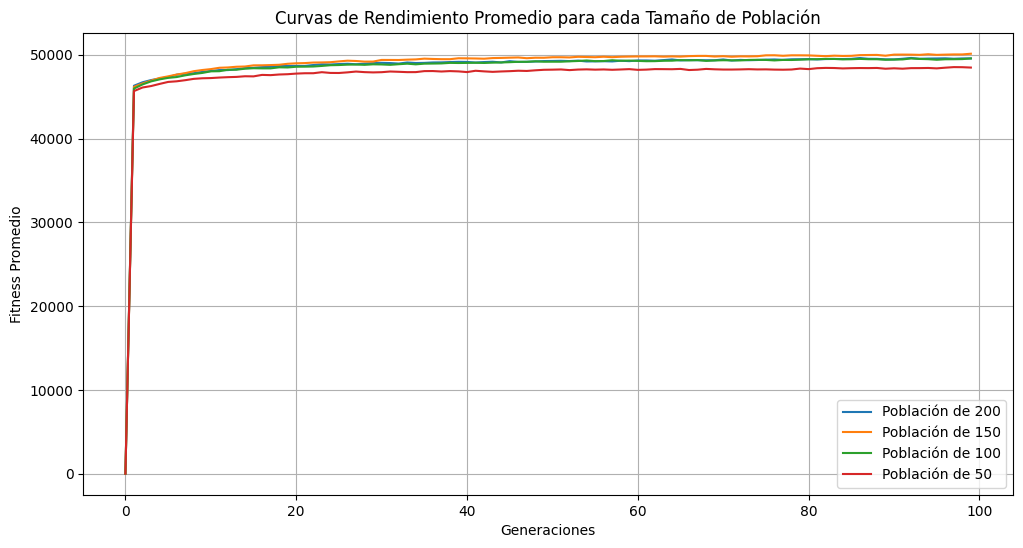

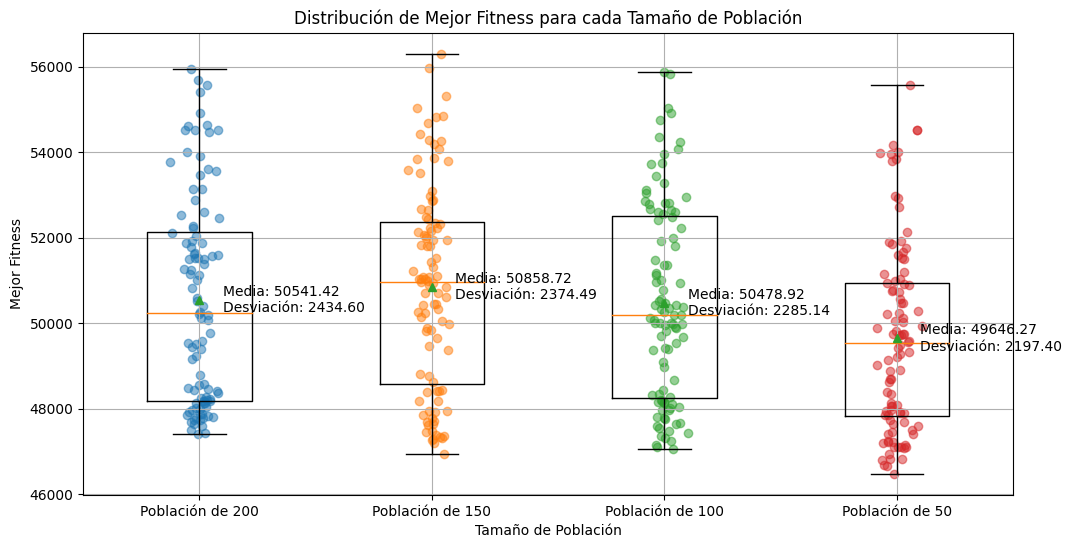

In [ ]:
plot_results(results, "Tamaño de Población")

#### ANOVA

In [ ]:
# Convertir datos a un DataFrame
best_fitnesses = results["best_fitnesses"]
data = [{'Population': label, 'Fitness': value} for label, values in best_fitnesses for value in values]
df = pd.DataFrame(data)

df = pd.DataFrame(data, columns=['Population', 'Fitness'])
anova(df, "Fitness", "Population")

Resultados ANOVA:
                    sum_sq     df         F    PR(>F)
C(Población)  8.033670e+07    3.0  4.905848  0.002332
Residual      2.161593e+09  396.0       NaN       NaN


ANOVA Tabla:

El valor p (0.002332) es menor que el nivel de significancia típico (0.05), lo que indica que hay una diferencia significativa entre las medias de al menos uno de los grupos.

#### Prueba de medias (Tukey)

Diferencia Honesta Significativa de Tukey:
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1           group2      meandiff p-adj    lower      upper   reject
-----------------------------------------------------------------------------
Población de 100 Población de 150    379.8  0.659  -472.6511 1232.2511  False
Población de 100 Población de 200     62.5 0.9976  -789.9511  914.9511  False
Población de 100  Población de 50  -832.65 0.0584 -1685.1011   19.8011  False
Población de 150 Población de 200   -317.3  0.772 -1169.7511  535.1511  False
Población de 150  Población de 50 -1212.45 0.0016 -2064.9011 -359.9989   True
Población de 200  Población de 50  -895.15 0.0353 -1747.6011  -42.6989   True
-----------------------------------------------------------------------------


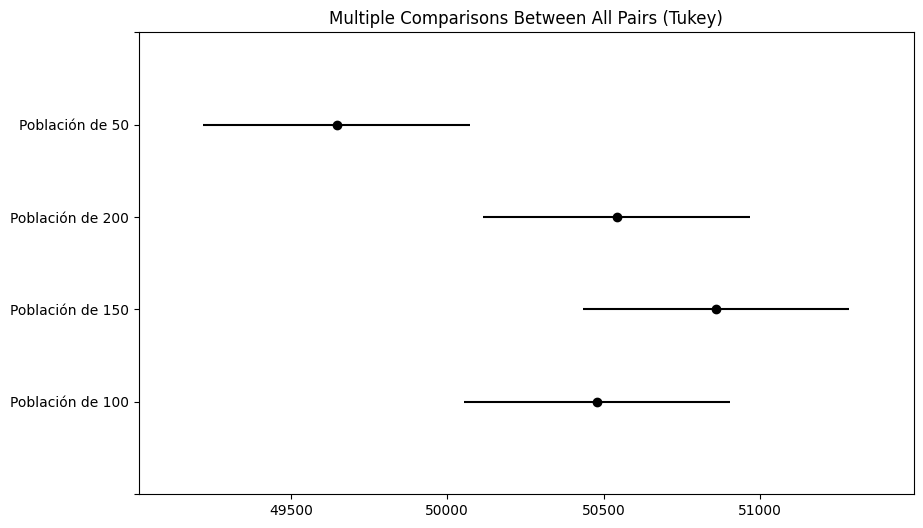

In [ ]:
test_tukey(df, "Fitness", "Population")

Tabla de Tukey:

Solo existen diferencias significativas en el fitness promedio entre las poblaciones de 150 y 50, y entre las poblaciones de 200 y 50.

#### Parámetro escogido

Se escoge una población de 150 individuos por sobre la de 200, para minimizar el tiempo de ejecución de la implementación.

### Ajuste de la función de selección

In [ ]:
problem = MKP()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb5.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
num_instances =  int(file.next_token())
problem.instance_loader(file)
parameter_values = [(BGA.Selection.TOURNAMENT, "Torneo con k=5", 5), (BGA.Selection.TOURNAMENT, "Torneo con k=10", 10), (BGA.Selection.TOURNAMENT, "Torneo con k=20", 20), (BGA.Selection.ROULETTE_WHEEL, "Ruleta", None)]
parameters_fixed = {"Population": {BGA.Population.SIZE: 150}}
results = parameter_tuning(problem, iterations = 100, generations = 100, parameter_values = parameter_values, parameters_fixed=parameters_fixed,verbose=True)

Iteración: 1 Parámetro: Torneo con k=5
Iteración: 2 Parámetro: Torneo con k=5
Iteración: 3 Parámetro: Torneo con k=5
Iteración: 4 Parámetro: Torneo con k=5
Iteración: 5 Parámetro: Torneo con k=5
Iteración: 6 Parámetro: Torneo con k=5
Iteración: 7 Parámetro: Torneo con k=5
Iteración: 8 Parámetro: Torneo con k=5
Iteración: 9 Parámetro: Torneo con k=5
Iteración: 10 Parámetro: Torneo con k=5
Iteración: 11 Parámetro: Torneo con k=5
Iteración: 12 Parámetro: Torneo con k=5
Iteración: 13 Parámetro: Torneo con k=5
Iteración: 14 Parámetro: Torneo con k=5
Iteración: 15 Parámetro: Torneo con k=5
Iteración: 16 Parámetro: Torneo con k=5
Iteración: 17 Parámetro: Torneo con k=5
Iteración: 18 Parámetro: Torneo con k=5
Iteración: 19 Parámetro: Torneo con k=5
Iteración: 20 Parámetro: Torneo con k=5
Iteración: 21 Parámetro: Torneo con k=5
Iteración: 22 Parámetro: Torneo con k=5
Iteración: 23 Parámetro: Torneo con k=5
Iteración: 24 Parámetro: Torneo con k=5
Iteración: 25 Parámetro: Torneo con k=5
Iteración

#### Curvas de rendimiento promedio

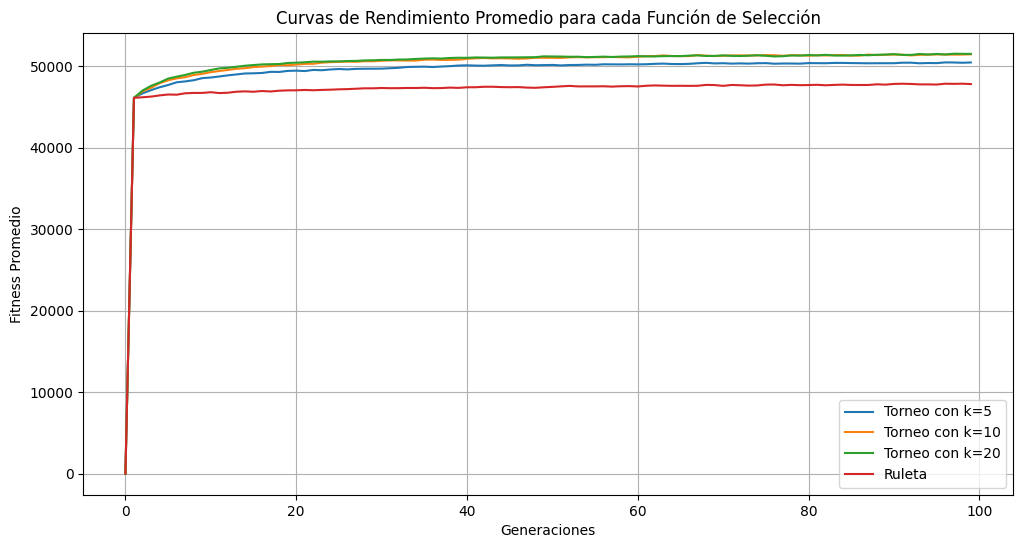

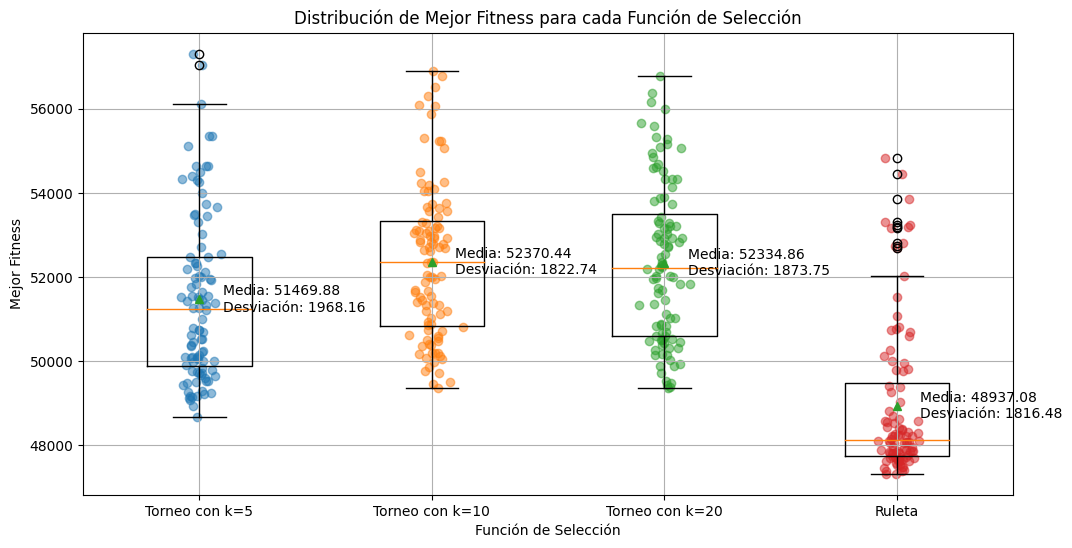

In [ ]:
plot_results(results, "Función de Selección")

#### ANOVA

In [ ]:
# Convertir datos a un DataFrame
best_fitnesses = results["best_fitnesses"]
data = [{'Selection': label, 'Fitness': value} for label, values in best_fitnesses for value in values]
df = pd.DataFrame(data)

df = pd.DataFrame(data, columns=['Selection', 'Fitness'])
anova(df, "Fitness", "Selection")

Resultados ANOVA:
                    sum_sq     df          F        PR(>F)
C(Selection)  7.827103e+08    3.0  73.763917  6.416806e-38
Residual      1.400654e+09  396.0        NaN           NaN


ANOVA Tabla:

El valor p (6.416806e-38) es menor que el nivel de significancia típico (0.05), lo que indica que hay una diferencia significativa entre las medias de al menos uno de los grupos.

#### Prueba de medias (Tukey)

Diferencia Honesta Significativa de Tukey:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
     group1          group2     meandiff p-adj    lower      upper   reject
---------------------------------------------------------------------------
         Ruleta Torneo con k=10  3433.36    0.0  2747.1643 4119.5557   True
         Ruleta Torneo con k=20  3397.78    0.0  2711.5843 4083.9757   True
         Ruleta  Torneo con k=5   2532.8    0.0  1846.6043 3218.9957   True
Torneo con k=10 Torneo con k=20   -35.58 0.9991  -721.7757  650.6157  False
Torneo con k=10  Torneo con k=5  -900.56 0.0043 -1586.7557 -214.3643   True
Torneo con k=20  Torneo con k=5  -864.98 0.0068 -1551.1757 -178.7843   True
---------------------------------------------------------------------------


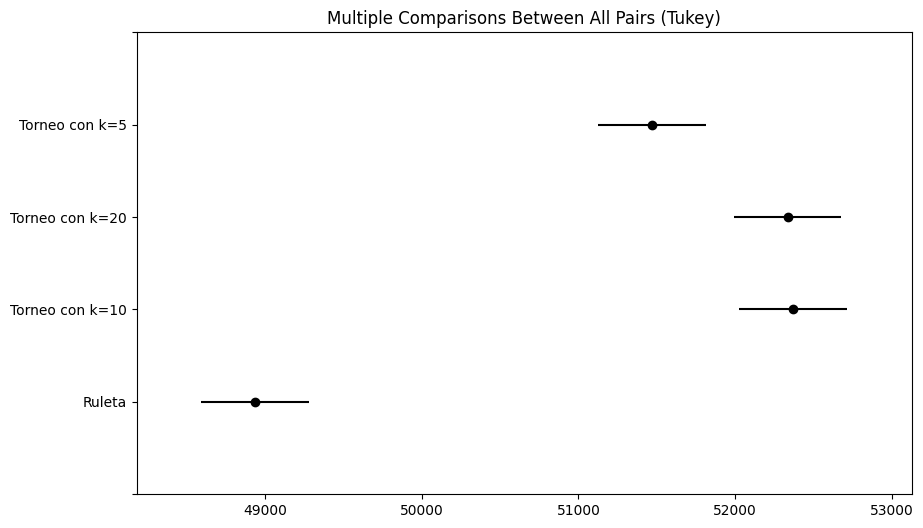

In [ ]:
test_tukey(df, "Fitness", "Selection")

Tabla de Tukey:

No existen diferencias significativas en el fitness promedio solo entre las funciones de selección de torneo con k=10 y k=20.

#### Parámetro escogido

Se escoge la función de selección por torneo con k=10 por sobre k=20, para minimizar el tiempo de ejecución de la implementación.

### Ajuste de la función de cruzamiento

In [ ]:
problem = MKP()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb5.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
num_instances =  int(file.next_token())
problem.instance_loader(file)
parameter_values = [(BGA.Crossover.UNIFORM, "Crossover uniforme con probabilidad 0.5", 0.5), (BGA.Crossover.UNIFORM, "Crossover uniforme con probabilidad 0.7", 0.7), (BGA.Crossover.ONE_POINT, "Crossover de un punto", None)]
parameters_fixed = {"Population": {BGA.Population.SIZE: 150},
                    "Selection":{BGA.Selection.TOURNAMENT: 10}}
results = parameter_tuning(problem, iterations = 100, generations = 100, parameter_values = parameter_values, parameters_fixed=parameters_fixed,verbose=True)

Iteración: 1 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 2 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 3 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 4 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 5 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 6 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 7 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 8 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 9 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 10 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 11 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 12 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 13 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 14 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 15 Parámetro: Crossover uniforme con probabilidad 0.5
Iteración: 16 Parámetro: Crossover

#### Curvas de rendimiento promedio

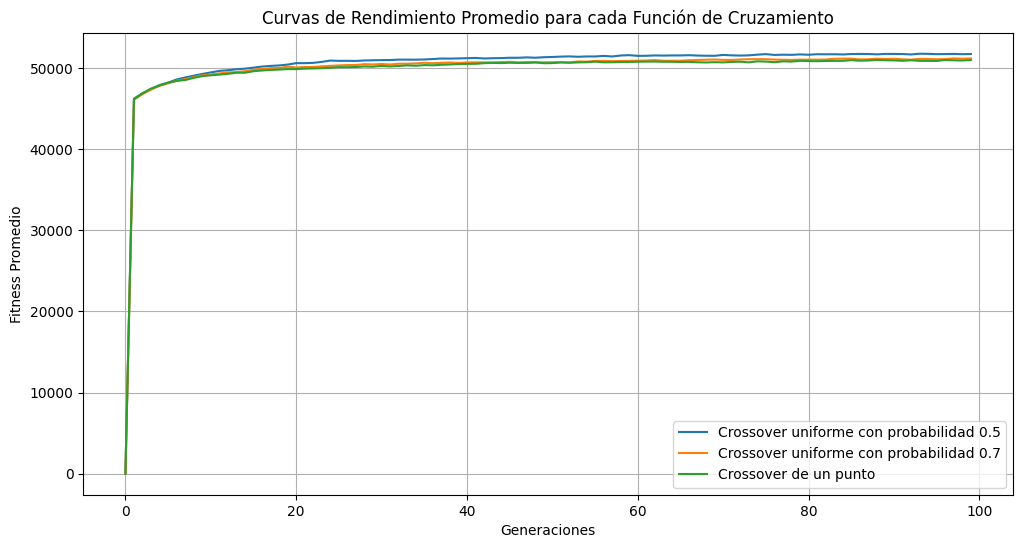

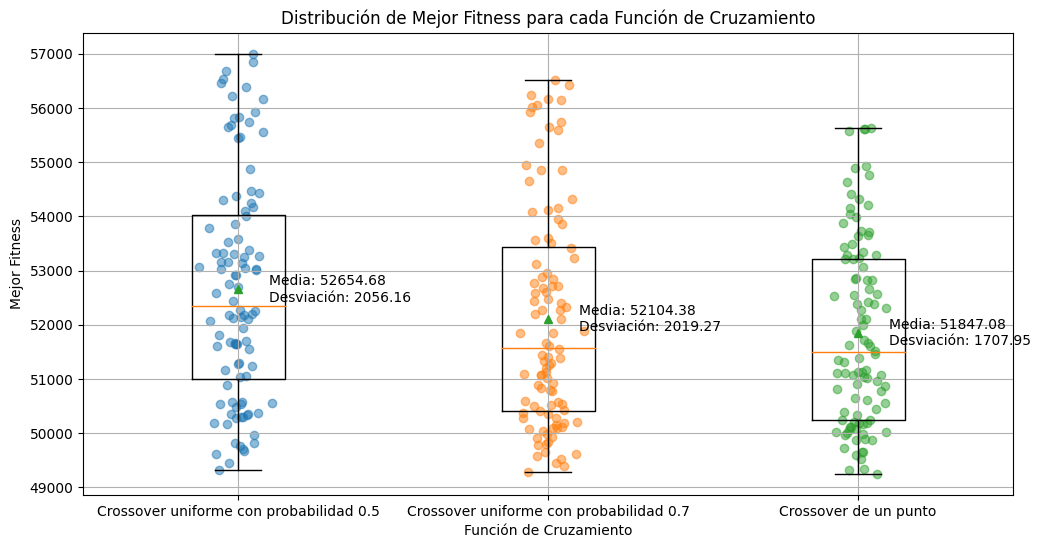

In [ ]:
plot_results(results, "Función de Cruzamiento")

#### ANOVA

In [ ]:
# Convertir datos a un DataFrame
best_fitnesses = results["best_fitnesses"]
data = [{'Crossover': label, 'Fitness': value} for label, values in best_fitnesses for value in values]
df = pd.DataFrame(data)

df = pd.DataFrame(data, columns=['Crossover', 'Fitness'])
anova(df, "Fitness", "Crossover")

Resultados ANOVA:
                    sum_sq     df         F    PR(>F)
C(Crossover)  3.404170e+07    2.0  4.504585  0.011824
Residual      1.122233e+09  297.0       NaN       NaN


ANOVA Tabla:

El valor p (0.011824) es menor que el nivel de significancia típico (0.05), lo que indica que hay una diferencia significativa entre las medias de al menos uno de los grupos.

#### Prueba de medias (Tukey)

Diferencia Honesta Significativa de Tukey:
                                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                                   
                 group1                                  group2                 meandiff p-adj    lower    upper   reject
-------------------------------------------------------------------------------------------------------------------------
                  Crossover de un punto Crossover uniforme con probabilidad 0.5    807.6 0.0099   160.061 1455.139   True
                  Crossover de un punto Crossover uniforme con probabilidad 0.7    257.3  0.618  -390.239  904.839  False
Crossover uniforme con probabilidad 0.5 Crossover uniforme con probabilidad 0.7   -550.3 0.1135 -1197.839   97.239  False
-------------------------------------------------------------------------------------------------------------------------


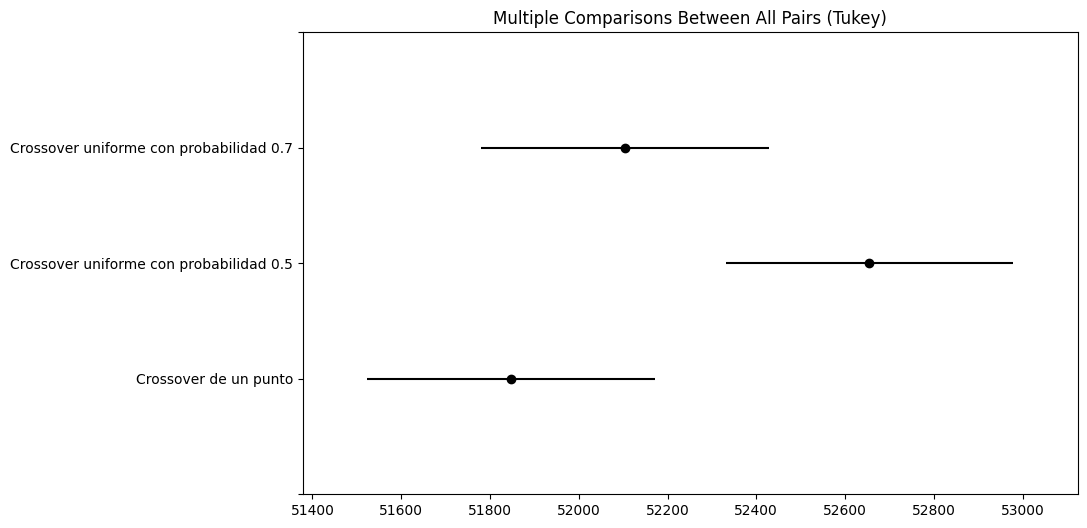

In [ ]:
test_tukey(df, "Fitness", "Crossover")

Tabla de Tukey:

Solo existen diferencias significativas en el fitness promedio entre las funciones de cruzamiento de un punto y cruzamiento uniforme con probabilidad de 0.5.

#### Parámetro escogido

Se escoge la función de cruzamiento uniforme con probabilidad de 0.5.

### Ajuste de la función de mutación

In [ ]:
problem = MKP()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb5.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
num_instances =  int(file.next_token())
problem.instance_loader(file)
parameter_values = [(BGA.Mutation.BIT_FLIP, "Mutación con probabilidad 0.01", 0.01), (BGA.Mutation.BIT_FLIP, "Mutación con probabilidad 0.05", 0.05), (BGA.Mutation.BIT_FLIP, "Mutación con probabilidad 0.1", 0.1)]
parameters_fixed = {"Population": {BGA.Population.SIZE: 150},
                    "Selection":{BGA.Selection.TOURNAMENT: 10},
                    "Crossover":{BGA.Crossover.UNIFORM: 0.5}}
results = parameter_tuning(problem, iterations = 100, generations = 100, parameter_values = parameter_values, parameters_fixed=parameters_fixed,verbose=True)

Iteración: 1 Parámetro: Mutación con probabilidad 0.01
Iteración: 2 Parámetro: Mutación con probabilidad 0.01
Iteración: 3 Parámetro: Mutación con probabilidad 0.01
Iteración: 4 Parámetro: Mutación con probabilidad 0.01
Iteración: 5 Parámetro: Mutación con probabilidad 0.01
Iteración: 6 Parámetro: Mutación con probabilidad 0.01
Iteración: 7 Parámetro: Mutación con probabilidad 0.01
Iteración: 8 Parámetro: Mutación con probabilidad 0.01
Iteración: 9 Parámetro: Mutación con probabilidad 0.01
Iteración: 10 Parámetro: Mutación con probabilidad 0.01
Iteración: 11 Parámetro: Mutación con probabilidad 0.01
Iteración: 12 Parámetro: Mutación con probabilidad 0.01
Iteración: 13 Parámetro: Mutación con probabilidad 0.01
Iteración: 14 Parámetro: Mutación con probabilidad 0.01
Iteración: 15 Parámetro: Mutación con probabilidad 0.01
Iteración: 16 Parámetro: Mutación con probabilidad 0.01
Iteración: 17 Parámetro: Mutación con probabilidad 0.01
Iteración: 18 Parámetro: Mutación con probabilidad 0.01
I

#### Curvas de rendimiento promedio

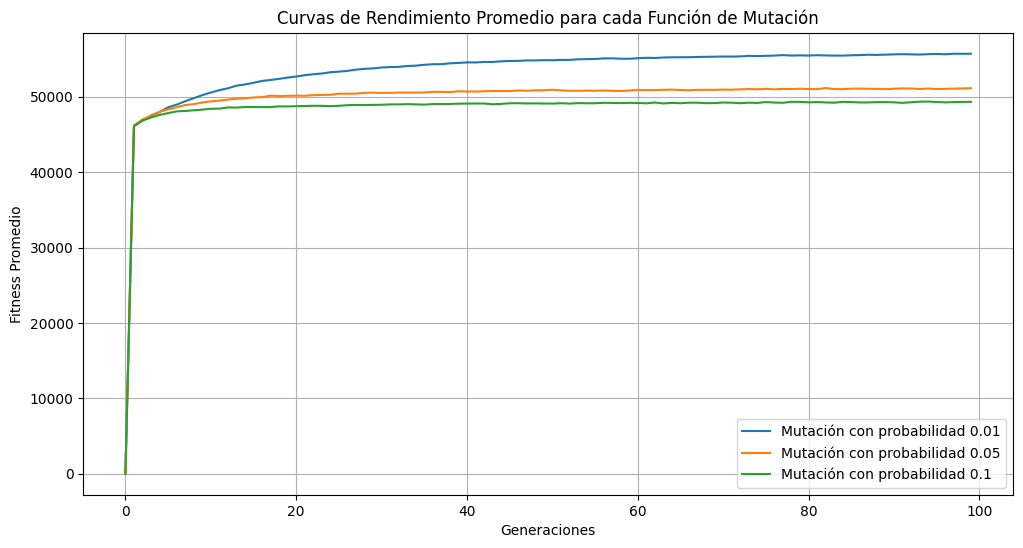

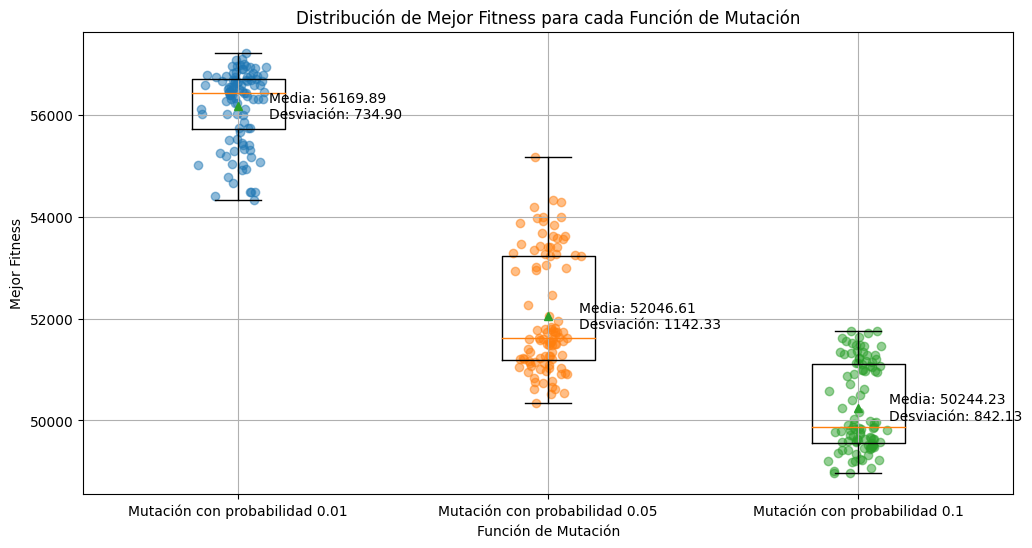

In [ ]:
plot_results(results, "Función de Mutación")

#### ANOVA

In [ ]:
# Convertir datos a un DataFrame
best_fitnesses = results["best_fitnesses"]
data = [{'Mutation': label, 'Fitness': value} for label, values in best_fitnesses for value in values]
df = pd.DataFrame(data)

df = pd.DataFrame(data, columns=['Mutation', 'Fitness'])
anova(df, "Fitness", "Mutation")

Resultados ANOVA:
                   sum_sq     df            F         PR(>F)
C(Mutation)  1.845449e+09    2.0  1072.944554  1.260740e-136
Residual     2.554178e+08  297.0          NaN            NaN


ANOVA Tabla:

El valor p (1.260740e-136) es menor que el nivel de significancia típico (0.05), lo que indica que hay una diferencia significativa entre las medias de al menos uno de los grupos.

#### Prueba de medias (Tukey)

Diferencia Honesta Significativa de Tukey:
                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                         group2             meandiff p-adj   lower      upper    reject
---------------------------------------------------------------------------------------------------------
Mutación con probabilidad 0.01 Mutación con probabilidad 0.05 -4123.28   0.0 -4432.2028 -3814.3572   True
Mutación con probabilidad 0.01  Mutación con probabilidad 0.1 -5925.66   0.0 -6234.5828 -5616.7372   True
Mutación con probabilidad 0.05  Mutación con probabilidad 0.1 -1802.38   0.0 -2111.3028 -1493.4572   True
---------------------------------------------------------------------------------------------------------


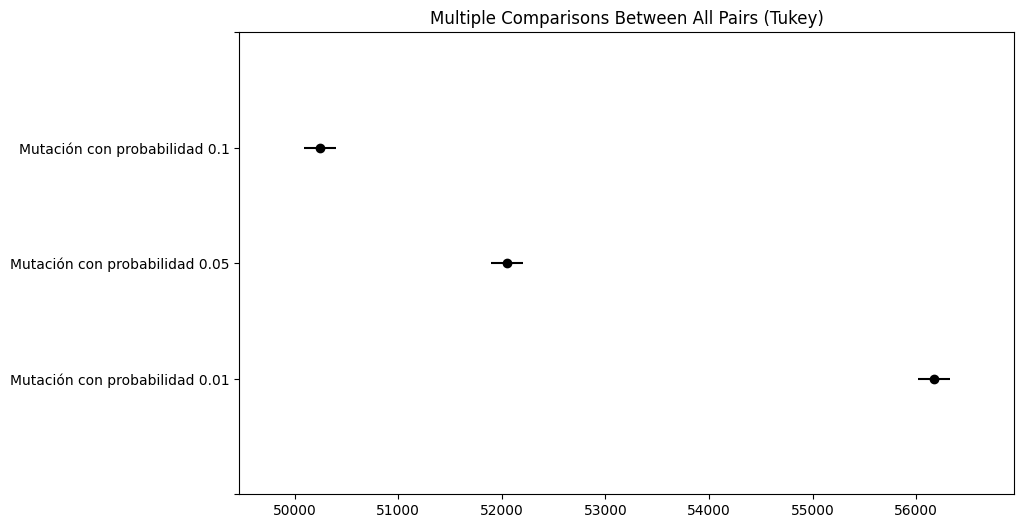

In [ ]:
test_tukey(df, "Fitness", "Mutation")

Tabla de Tukey:

Existen diferencias significativas en el fitness promedio entre todas las funciones de mutación

#### Parámetro escogido

Se escoge una probabilidad de mutación del 1%.

### Ajuste de la función de reemplazo

In [ ]:
problem = MKP()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb5.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
num_instances =  int(file.next_token())
problem.instance_loader(file)
parameter_values = [(BGA.Replace.COMPLETE, "Reemplazo completo", None), (BGA.Replace.ELITISM, "Reemplazo elitista con e=0.1", 0.1), (BGA.Replace.ELITISM, "Reemplazo elitista con e=0.25", 0.25), (BGA.Replace.ELITISM, "Reemplazo elitista con e=0.5", 0.5), (BGA.Replace.ROULETTE_WHEEL, "Reemplazo por ruleta", None)]
parameters_fixed = {"Population": {BGA.Population.SIZE: 150},
                    "Selection":{BGA.Selection.TOURNAMENT: 10},
                    "Crossover":{BGA.Crossover.UNIFORM: 0.5},
                    "Mutation":{BGA.Mutation.BIT_FLIP: 0.01}}
results = parameter_tuning(problem, iterations = 100, generations = 100, parameter_values = parameter_values, parameters_fixed=parameters_fixed,verbose=True)

Iteración: 1 Parámetro: Reemplazo completo
Iteración: 2 Parámetro: Reemplazo completo
Iteración: 3 Parámetro: Reemplazo completo
Iteración: 4 Parámetro: Reemplazo completo
Iteración: 5 Parámetro: Reemplazo completo
Iteración: 6 Parámetro: Reemplazo completo
Iteración: 7 Parámetro: Reemplazo completo
Iteración: 8 Parámetro: Reemplazo completo
Iteración: 9 Parámetro: Reemplazo completo
Iteración: 10 Parámetro: Reemplazo completo
Iteración: 11 Parámetro: Reemplazo completo
Iteración: 12 Parámetro: Reemplazo completo
Iteración: 13 Parámetro: Reemplazo completo
Iteración: 14 Parámetro: Reemplazo completo
Iteración: 15 Parámetro: Reemplazo completo
Iteración: 16 Parámetro: Reemplazo completo
Iteración: 17 Parámetro: Reemplazo completo
Iteración: 18 Parámetro: Reemplazo completo
Iteración: 19 Parámetro: Reemplazo completo
Iteración: 20 Parámetro: Reemplazo completo
Iteración: 21 Parámetro: Reemplazo completo
Iteración: 22 Parámetro: Reemplazo completo
Iteración: 23 Parámetro: Reemplazo comple

#### Curvas de rendimiento promedio

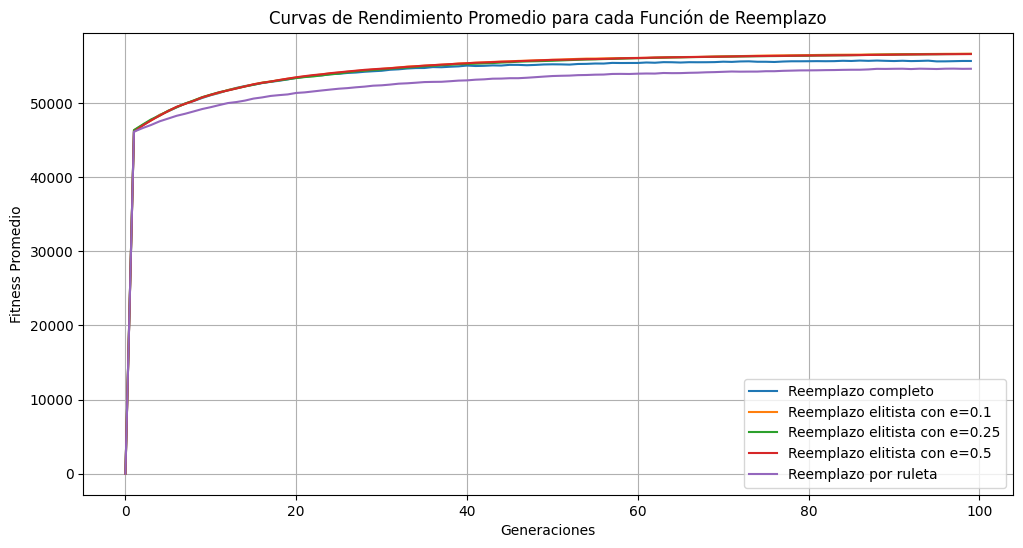

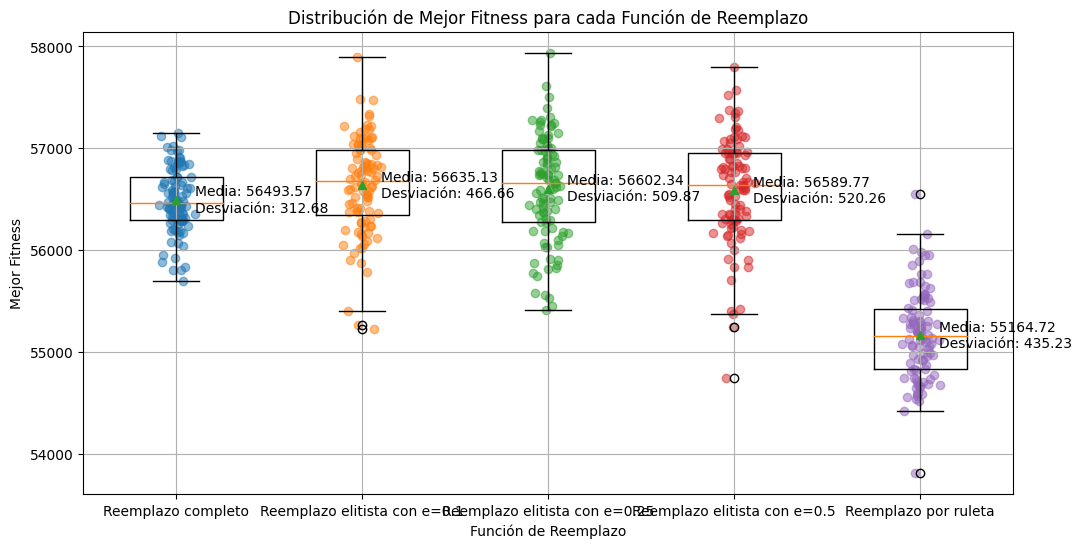

In [ ]:
plot_results(results, "Función de Reemplazo")

#### ANOVA

In [ ]:
# Convertir datos a un DataFrame
best_fitnesses = results["best_fitnesses"]
data = [{'Replace': label, 'Fitness': value} for label, values in best_fitnesses for value in values]
df = pd.DataFrame(data)

df = pd.DataFrame(data, columns=['Replace', 'Fitness'])
anova(df, "Fitness", "Replace")

Resultados ANOVA:
                  sum_sq     df           F        PR(>F)
C(Replace)  1.613976e+08    4.0  192.862799  1.604389e-99
Residual    1.035604e+08  495.0         NaN           NaN


ANOVA Tabla:

El valor p (1.604389e-99) es menor que el nivel de significancia típico (0.05), lo que indica que hay una diferencia significativa entre las medias de al menos uno de los grupos.

#### Prueba de medias (Tukey)

Diferencia Honesta Significativa de Tukey:
                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
            group1                        group2            meandiff p-adj    lower      upper    reject
--------------------------------------------------------------------------------------------------------
           Reemplazo completo  Reemplazo elitista con e=0.1   141.56 0.1857   -35.5408   318.6608  False
           Reemplazo completo Reemplazo elitista con e=0.25   108.77 0.4464   -68.3308   285.8708  False
           Reemplazo completo  Reemplazo elitista con e=0.5     96.2 0.5713   -80.9008   273.3008  False
           Reemplazo completo          Reemplazo por ruleta -1328.85    0.0 -1505.9508 -1151.7492   True
 Reemplazo elitista con e=0.1 Reemplazo elitista con e=0.25   -32.79 0.9867  -209.8908   144.3108  False
 Reemplazo elitista con e=0.1  Reemplazo elitista con e=0.5   -45.36 0.9562  -222.4608   131.7408  False
 Reemplazo e

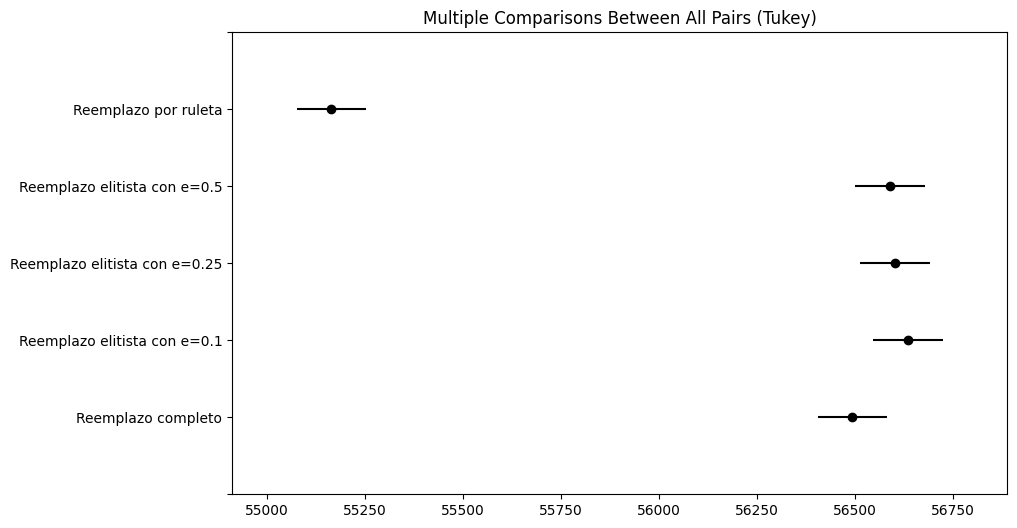

In [ ]:
test_tukey(df, "Fitness", "Replace")

Tabla de Tukey:

Existen diferencias significativas en el fitness promedio de la función de reemplazo por ruleta con el resto de funciones de reemplazo.

#### Parámetro escogido

Se escoge la función de reemplazo elitista con e=10% por sobre el resto, para minimizar el tiempo de ejecución de la implementación.

# Ejecución de los métodos de resolución

## Implementación Greedy

### Prueba con una instancia conocida

In [ ]:
problem = MKP()
problem.instance = [[3,8,5,7,9],
                    [5,5,5,8,13],
                    [2,9,5,5,13],
                    [3,3,10,8,18],
                    [10,28,12,32,53]]
problem.num_objects = 4
problem.num_dimensions = 4

problem.print_instance()
solution, value_solution, remaining_rest, remaining_obj = problem.solve_greedy()
print(f"Solución: {solution}")
print(f"Ganancia obtenida: {value_solution}")
print(f"Espacio restante: {remaining_rest[:-1:]}")

Objeto 1: [3, 8, 5, 7, 9]
Objeto 2: [5, 5, 5, 8, 13]
Objeto 3: [2, 9, 5, 5, 13]
Objeto 4: [3, 3, 10, 8, 18]
Restricciones: [10, 28, 12, 32, 53]
Cantidad de objetos: 4
Cantidad de dimensiones: 4
Solución: [0, 1, 1, 0]
Ganancia obtenida: 26
Espacio restante: [3, 14, 2, 19]


### Prueba con el generador de instancias aleatorias

In [ ]:
problem = MKP()
for i in range(1000):
  problem.instance_generator()
  solution, value_solution, remaining_rest, remaining_obj = problem.solve_greedy()
  print(f"Solución: {solution}")
  print(f"Ganancia obtenida: {value_solution}")
  print(f"Espacio restante: {remaining_rest[:-1:]}")

Solución: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ganancia obtenida: 728
Espacio restante: [20, 36, 21, 51, 42, 41, 47, 32, 47, 13, 48, 21, 8, 14, 15, 31, 29, 56, 20, 11, 41, 11, 11, 1, 30, 43, 17, 30, 7, 21, 48, 45, 17, 48, 10, 23, 13, 34, 55, 45, 31, 36, 18, 28, 44, 29, 19, 28, 38, 28, 0, 33, 25, 47, 13, 59, 38, 23, 42, 0, 4, 54, 16, 33]
Solución: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ganancia obtenida: 599
Espacio restante: [35, 2, 47, 56, 30, 11, 26, 19, 20, 49, 9, 35, 28, 26, 50, 23, 9, 49, 18, 44, 46, 9, 29, 20, 15, 59, 34, 12, 34, 6, 27, 52, 10, 20, 36, 31, 36, 10, 45, 41, 28, 38, 44, 10, 15, 37]
Solución: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0

### Prueba con las instancias mknapcb1.txt

In [ ]:
problem = MKP()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb1.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
num_instances =  int(file.next_token())
for i in range(num_instances):
  problem.instance_loader(file)
  problem.print_instance()
  solution, value_solution, remaining_rest, remaining_obj = problem.solve_greedy()
  print(f"Solución: {solution}")
  print(f"Ganancia obtenida: {value_solution}")
  print(f"Valor óptimo de referencia: {problem.optimun_value}")
  print(f"Espacio restante: {remaining_rest[:-1:]}\n")

Objeto 1: [475.0, 404.0, 806.0, 509.0, 42.0, 504.0]
Objeto 2: [36.0, 197.0, 361.0, 883.0, 41.0, 803.0]
Objeto 3: [287.0, 817.0, 199.0, 229.0, 523.0, 667.0]
Objeto 4: [577.0, 1000.0, 781.0, 569.0, 215.0, 1103.0]
Objeto 5: [45.0, 44.0, 596.0, 706.0, 819.0, 834.0]
Objeto 6: [700.0, 307.0, 669.0, 639.0, 551.0, 585.0]
Objeto 7: [803.0, 39.0, 957.0, 114.0, 69.0, 811.0]
Objeto 8: [654.0, 659.0, 358.0, 727.0, 193.0, 856.0]
Objeto 9: [196.0, 46.0, 259.0, 491.0, 582.0, 690.0]
Objeto 10: [844.0, 334.0, 888.0, 481.0, 375.0, 832.0]
Objeto 11: [657.0, 448.0, 319.0, 681.0, 367.0, 846.0]
Objeto 12: [387.0, 599.0, 751.0, 948.0, 478.0, 813.0]
Objeto 13: [518.0, 931.0, 275.0, 687.0, 162.0, 868.0]
Objeto 14: [143.0, 776.0, 177.0, 941.0, 898.0, 793.0]
Objeto 15: [515.0, 263.0, 883.0, 350.0, 550.0, 825.0]
Objeto 16: [335.0, 980.0, 749.0, 253.0, 553.0, 1002.0]
Objeto 17: [942.0, 807.0, 229.0, 573.0, 298.0, 860.0]
Objeto 18: [701.0, 378.0, 265.0, 40.0, 577.0, 615.0]
Objeto 19: [332.0, 278.0, 282.0, 124.0, 493

## Metaheurística Binary Genetic Algorithm (BGA)

### Prueba con una instancia conocida

In [ ]:
problem = MKP()
problem.instance = [[3,8,5,7,9],
                    [5,5,5,8,13],
                    [2,9,5,5,13],
                    [3,3,10,8,18],
                    [10,28,12,32,53]]
problem.num_objects = 4
problem.num_dimensions = 4

problem.print_instance()
solution, value_solution, best_fitnesses = problem.binary_genetic_algorithm(10,10)
print(f"Solución: {solution}")
print(f"Ganancia obtenida: {value_solution}")
print(f"Mejor solución de cada generación: {best_fitnesses}")

Objeto 1: [3, 8, 5, 7, 9]
Objeto 2: [5, 5, 5, 8, 13]
Objeto 3: [2, 9, 5, 5, 13]
Objeto 4: [3, 3, 10, 8, 18]
Restricciones: [10, 28, 12, 32, 53]
Cantidad de objetos: 4
Cantidad de dimensiones: 4
Solución: [0, 1, 1, 0]
Ganancia obtenida: 26
Mejor solución de cada generación: [26, 26, 26, 26, 26, 26, 26, 26, 26, 26]


### Prueba con el generador de instancias aleatorias

In [ ]:
problem = MKP()
for i in range(10):
  problem.instance_generator()
  solution, value_solution, best_fitnesses = problem.binary_genetic_algorithm(verbose = False)
  print(f"Solución: {solution}")
  print(f"Ganancia obtenida: {value_solution}")

Solución: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Ganancia obtenida: 665
Solución: [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
Ganancia obtenida: 836
Solución: [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Ganancia obtenida: 79
Solución: [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]
Ganancia obtenida: 176
Solución: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ganancia obtenida: 798
Solución: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1

### Prueba con la primera instancia de mknapcb1.txt

In [ ]:
problem = MKP()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb1.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
num_instances =  int(file.next_token())
for i in range(num_instances):
  if i == 0:
    problem.instance_loader(file)
    problem.print_instance()
    uniform_crossover = partial(MKP.uniform_crossover, prob_crossover = 0.7)
    one_point_crossover = partial(MKP.one_point_crossover)
    tournament_selection = partial(MKP.tournament_selection, k = 25)
    complete_replace = partial(MKP.complete_replace)
    solution, value_solution, best_fitnesses = problem.binary_genetic_algorithm(crossover = one_point_crossover,
                                                                selection = tournament_selection,
                                                                replace_population = complete_replace)
    print(f"Solución: {solution}")
    print(f"Ganancia obtenida: {value_solution}")
    print(f"Valor óptimo de referencia: {problem.optimun_value}")

Objeto 1: [475.0, 404.0, 806.0, 509.0, 42.0, 504.0]
Objeto 2: [36.0, 197.0, 361.0, 883.0, 41.0, 803.0]
Objeto 3: [287.0, 817.0, 199.0, 229.0, 523.0, 667.0]
Objeto 4: [577.0, 1000.0, 781.0, 569.0, 215.0, 1103.0]
Objeto 5: [45.0, 44.0, 596.0, 706.0, 819.0, 834.0]
Objeto 6: [700.0, 307.0, 669.0, 639.0, 551.0, 585.0]
Objeto 7: [803.0, 39.0, 957.0, 114.0, 69.0, 811.0]
Objeto 8: [654.0, 659.0, 358.0, 727.0, 193.0, 856.0]
Objeto 9: [196.0, 46.0, 259.0, 491.0, 582.0, 690.0]
Objeto 10: [844.0, 334.0, 888.0, 481.0, 375.0, 832.0]
Objeto 11: [657.0, 448.0, 319.0, 681.0, 367.0, 846.0]
Objeto 12: [387.0, 599.0, 751.0, 948.0, 478.0, 813.0]
Objeto 13: [518.0, 931.0, 275.0, 687.0, 162.0, 868.0]
Objeto 14: [143.0, 776.0, 177.0, 941.0, 898.0, 793.0]
Objeto 15: [515.0, 263.0, 883.0, 350.0, 550.0, 825.0]
Objeto 16: [335.0, 980.0, 749.0, 253.0, 553.0, 1002.0]
Objeto 17: [942.0, 807.0, 229.0, 573.0, 298.0, 860.0]
Objeto 18: [701.0, 378.0, 265.0, 40.0, 577.0, 615.0]
Objeto 19: [332.0, 278.0, 282.0, 124.0, 493

### Prueba con la primera instancia de mknapcb5.txt

In [ ]:
problem = MKP()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb5.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
num_instances =  int(file.next_token())
for _ in range(1):
  problem.instance_loader(file)
  problem.print_instance()
  solution, value_solution, best_fitnesses = problem.binary_genetic_algorithm()
  print(f"Solución: {solution}")
  print(f"Ganancia obtenida: {value_solution}")
  print(f"Valor óptimo de referencia: {problem.optimun_value}")

Objeto 1: [759.0, 307.0, 714.0, 660.0, 543.0, 865.0, 909.0, 468.0, 422.0, 396.0, 992.0]
Objeto 2: [791.0, 464.0, 386.0, 663.0, 987.0, 626.0, 239.0, 664.0, 396.0, 63.0, 612.0]
Objeto 3: [73.0, 870.0, 736.0, 612.0, 922.0, 614.0, 481.0, 408.0, 538.0, 43.0, 582.0]
Objeto 4: [398.0, 471.0, 712.0, 454.0, 942.0, 517.0, 430.0, 316.0, 638.0, 279.0, 610.0]
Objeto 5: [158.0, 580.0, 112.0, 55.0, 777.0, 314.0, 589.0, 330.0, 984.0, 807.0, 495.0]
Objeto 6: [218.0, 279.0, 617.0, 4.0, 498.0, 708.0, 928.0, 149.0, 463.0, 710.0, 573.0]
Objeto 7: [662.0, 712.0, 957.0, 397.0, 879.0, 425.0, 277.0, 111.0, 536.0, 482.0, 608.0]
Objeto 8: [687.0, 347.0, 327.0, 681.0, 247.0, 765.0, 68.0, 285.0, 582.0, 339.0, 873.0]
Objeto 9: [35.0, 396.0, 660.0, 670.0, 159.0, 732.0, 386.0, 938.0, 612.0, 659.0, 636.0]
Objeto 10: [448.0, 430.0, 27.0, 7.0, 953.0, 542.0, 498.0, 687.0, 379.0, 810.0, 620.0]
Objeto 11: [954.0, 850.0, 376.0, 439.0, 317.0, 182.0, 238.0, 699.0, 386.0, 542.0, 560.0]
Objeto 12: [454.0, 832.0, 253.0, 871.0, 7

### Prueba con la primera instancia de mknapcb9.txt

In [ ]:
problem = MKP()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb9.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
num_instances =  int(file.next_token())
for _ in range(1):
  problem.instance_loader(file)
  solution, value_solution, best_fitnesses = problem.binary_genetic_algorithm()
  print(f"Solución: {solution}")
  print(f"Ganancia obtenida: {value_solution}")
  print(f"Valor óptimo de referencia: {problem.optimun_value}")

Aptitud de la población: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Generación 0, Mejor Aptitud: 0
Aptitud de la población: [82776.0, 82655.0, 85412.0, 82765.0, 81399.0, 85416.0, 86288.0, 83578.0, 84614.0, 87307.0, 85129.0, 86531.0, 88012.0, 86444.0, 85763.0, 85854.0, 82817.0, 86221.0, 84136.0, 84422.0, 82022.0, 86348.0, 85953.0, 81119.0, 86511.0, 85819.0, 83730.0, 86872.0, 81443.0, 79587.0, 83646.0, 85832.0, 83228.0, 83893.0, 85360.0, 80241.0, 82447.0, 83544.0, 83810.0, 86157.0, 86166.0, 82811.0, 85873.0, 85510.0, 90531.0, 79459.0, 85303.0, 84356.0, 84484.0, 85910.0, 85114.0, 80150.0, 84719.0, 82248.0, 87302.0, 84324.0, 84768.0, 82765.0, 84121.0, 84964.0, 80612.0, 82724.0, 86848.0, 84551.0, 83697.0, 86712.0, 83478.0, 84701.0, 83143

# Gráficos y resultados

## Comparación implementación Greedy versus BGA

El ejemplo de uso de la implementación está descrito como comentarios en los posteriores bloques de código, también puede hacer revisión de las pruebas con instancias variadas en la sección: *Metaheurística Binary Genetic Algorithm (BGA)* dentro de la sección: *Ejecución de los métodos de resolución*

Se destaca que los parámetros a usar en la metaheurística ya fueron seleccionadods en la sección: *Ajuste de parámetros para la metaheurística Binary Genetic Algorithm*.

**Estos son los siguientes:**

*   **Población:** Población de 150 individuos.
*   **Selección:** Selección por torneo con k=10.
*   **Cruzamiento:** Cruzamiento uniforme con probabilidad de 0.5.
*   **Mutación:** Mutación con probabilidad del 1%.
*   **Reemplazo:** Reemplazo elitista con e=0.1


**Ejemplo de uso de las funciones parciales:**

In [ ]:
#Ejemplo declaración de la función de cruzamiento uniforme
uniform_crossover = partial(MKP.uniform_crossover, prob_crossover = 0.7)

#Ejemplo declaración de la función de cruzamiento de un punto
one_point_crossover = partial(MKP.one_point_crossover)

#Ejemplo declaración de la función de selección por torneo con k=25
tournament_selection = partial(MKP.tournament_selection, k = 25)

#Ejemplo declaración de la función de reemplazo completo
complete_replace = partial(MKP.complete_replace)

### Primera instancia mknap1.txt

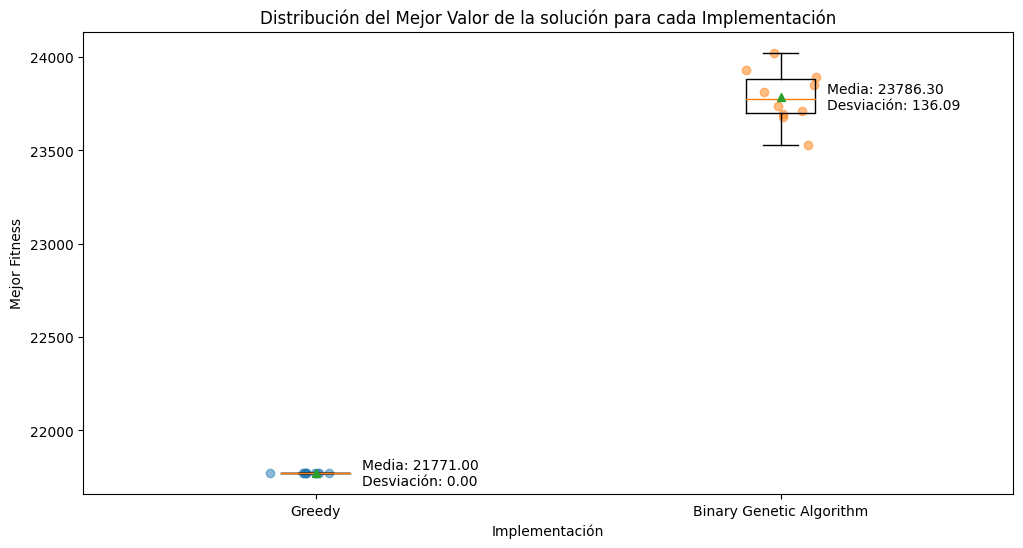

In [11]:
#Se instancia la clase que contendrá el problema y el BGA
problem = MKP()
#Se abre el archivo y se lee token por token con una clase propia = FILE()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb1.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
#Se obtiene el primer token con la cantidad de instancias
num_instances =  int(file.next_token())
#Se carga la primera instancia
problem.instance_loader(file)
#Se cargan las funciones que usará el BGA
selection = partial(MKP.tournament_selection, k = 10)
crossover = partial(MKP.uniform_crossover, prob_crossover = 0.5)
mutation = partial(MKP.bit_flip_mutation, prob_mutation = 0.01)
replace_population = partial(MKP.elitism_replace, e=0.1)

#Se comienza a resolver por ambos métodos
best_values_greedy = []
best_values_bga = []
best_solution_bga = [None, 0]
#Se iteran 10 ejecuciones
for i in range(10):
  _, best_value_greedy, _, _ = problem.solve_greedy()
  solution, best_value_bga, _ = problem.binary_genetic_algorithm(population_size=150,
                                                          generations=1000,
                                                          selection=selection,
                                                          crossover=crossover,
                                                          mutation=mutation,
                                                          replace_population=replace_population,
                                                          verbose=False)
  if best_value_bga > best_solution_bga[1]:
    best_solution_bga[0] = solution
    best_solution_bga[1] = best_value_bga
  best_values_greedy.append(best_value_greedy)
  best_values_bga.append(best_value_bga)
#Finaliza la ejecución y se guardan los resultados
best_values = [("Greedy", best_values_greedy),("Binary Genetic Algorithm", best_values_bga)]

# Graficar los gráficos de caja para best_values
plt.figure(figsize=(12, 6))
labels, data = zip(*best_values)
plt.boxplot(data, labels=labels, showmeans=True)

# Añadir media y desviación estándar a la gráfica de caja
for i, (label, y) in enumerate(best_values):
    x = np.random.normal(i + 1, 0.04, size=len(y))
    plt.scatter(x, y, alpha=0.5)
    mean = np.mean(y)
    std = np.std(y)
    plt.text(i + 1.1, mean, f'Media: {mean:.2f}\nDesviación: {std:.2f}', horizontalalignment='left', verticalalignment='center')

plt.xlabel('Implementación')
plt.ylabel('Mejor Fitness')
plt.title('Distribución del Mejor Valor de la solución para cada Implementación')
plt.show()

In [12]:
print("Mejor solución BGA:", best_solution_bga[0])
print("Mejor valor de la solución BGA:", best_solution_bga[1])
print("Valores obtenidos BGA:", best_values_bga)
print("Valores obtenidos Greedy:", best_values_greedy)

Mejor solución BGA: [0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Mejor valor de la solución BGA: 24021.0
Valores obtenidos BGA: [23697.0, 23850.0, 23714.0, 23812.0, 23529.0, 23895.0, 24021.0, 23929.0, 23680.0, 23736.0]
Valores obtenidos Greedy: [21771.0, 21771.0, 21771.0, 21771.0, 21771.0, 21771.0, 21771.0, 21771.0, 21771.0, 21771.0]


### Primera instancia mknap5.txt

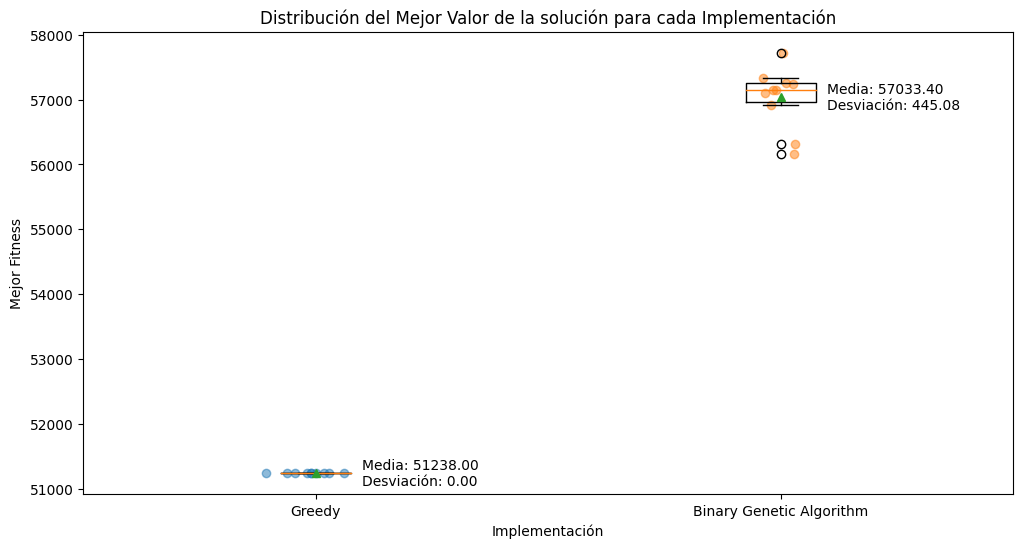

In [14]:
#Se instancia la clase que contendrá el problema y el BGA
problem = MKP()
#Se abre el archivo y se lee token por token con una clase propia = FILE()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb5.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
#Se obtiene el primer token con la cantidad de instancias
num_instances =  int(file.next_token())
#Se carga la primera instancia
problem.instance_loader(file)
#Se cargan las funciones que usará el BGA
selection = partial(MKP.tournament_selection, k = 10)
crossover = partial(MKP.uniform_crossover, prob_crossover = 0.5)
mutation = partial(MKP.bit_flip_mutation, prob_mutation = 0.01)
replace_population = partial(MKP.elitism_replace, e=0.1)

#Se comienza a resolver por ambos métodos
best_values_greedy = []
best_values_bga = []
best_solution_bga = [None, 0]
#Se iteran 10 ejecuciones
for i in range(10):
  _, best_value_greedy, _, _ = problem.solve_greedy()
  _, best_value_bga, _ = problem.binary_genetic_algorithm(population_size=150,
                                                          generations=250,
                                                          selection=selection,
                                                          crossover=crossover,
                                                          mutation=mutation,
                                                          replace_population=replace_population,
                                                          verbose=False)
  if best_value_bga > best_solution_bga[1]:
    best_solution_bga[0] = solution
    best_solution_bga[1] = best_value_bga
  best_values_greedy.append(best_value_greedy)
  best_values_bga.append(best_value_bga)
#Finaliza la ejecución y se guardan los resultados
best_values = [("Greedy", best_values_greedy),("Binary Genetic Algorithm", best_values_bga)]

# Graficar los gráficos de caja para best_values
plt.figure(figsize=(12, 6))
labels, data = zip(*best_values)
plt.boxplot(data, labels=labels, showmeans=True)

# Añadir media y desviación estándar a la gráfica de caja
for i, (label, y) in enumerate(best_values):
    x = np.random.normal(i + 1, 0.04, size=len(y))
    plt.scatter(x, y, alpha=0.5)
    mean = np.mean(y)
    std = np.std(y)
    plt.text(i + 1.1, mean, f'Media: {mean:.2f}\nDesviación: {std:.2f}', horizontalalignment='left', verticalalignment='center')

plt.xlabel('Implementación')
plt.ylabel('Mejor Fitness')
plt.title('Distribución del Mejor Valor de la solución para cada Implementación')
plt.show()

In [15]:
print("Mejor solución BGA:", best_solution_bga[0])
print("Mejor valor de la solución BGA:", best_solution_bga[1])
print("Valores obtenidos BGA:", best_values_bga)
print("Valores obtenidos Greedy:", best_values_greedy)

Mejor solución BGA: [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
Mejor valor de la solución BGA: 57715.0
Valores obtenidos BGA: [57248.0, 56157.0, 57152.0, 57101.0, 57333.0, 57150.0, 56909.0, 56315.0, 57254.0, 57715.0]
Valores obtenidos Greedy: [51238.0, 51238.0, 51238.0, 51238.0, 51238.0, 51238.0, 51238.0, 51238.0, 51238.0, 51238.0]


### Primera instancia mknap9.txt

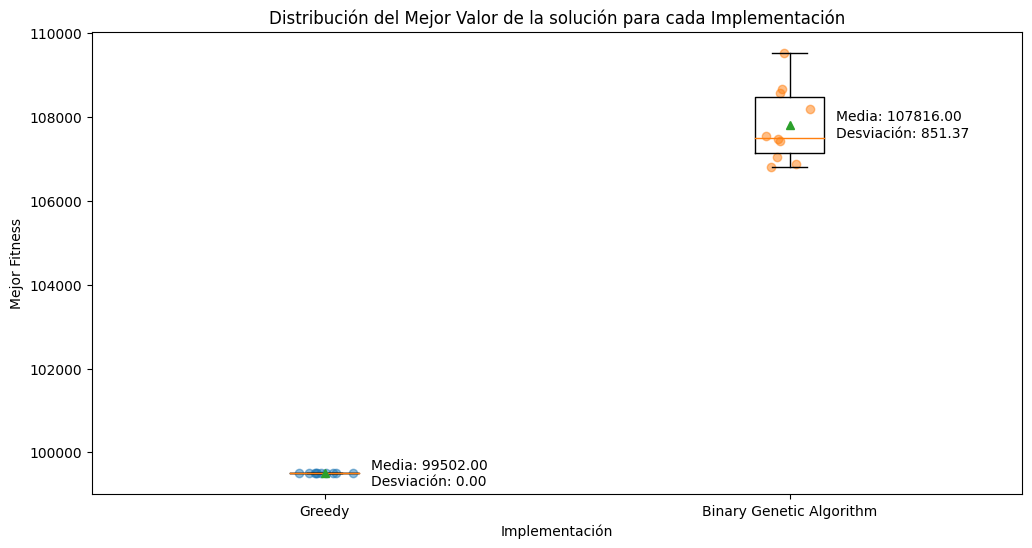

In [16]:
#Se instancia la clase que contendrá el problema y el BGA
problem = MKP()
#Se abre el archivo y se lee token por token con una clase propia = FILE()
with open("/content/drive/MyDrive/Instancias-MKP/mknapcb9.txt",'r') as f:
  file = File(f.read().split())
index_file = 0
#Se obtiene el primer token con la cantidad de instancias
num_instances =  int(file.next_token())
#Se carga la primera instancia
problem.instance_loader(file)
#Se cargan las funciones que usará el BGA
selection = partial(MKP.tournament_selection, k = 10)
crossover = partial(MKP.uniform_crossover, prob_crossover = 0.5)
mutation = partial(MKP.bit_flip_mutation, prob_mutation = 0.01)
replace_population = partial(MKP.elitism_replace, e=0.1)

#Se comienza a resolver por ambos métodos
best_values_greedy = []
best_values_bga = []
best_solution_bga = [None, 0]
#Se iteran 10 ejecuciones
for i in range(10):
  _, best_value_greedy, _, _ = problem.solve_greedy()
  _, best_value_bga, _ = problem.binary_genetic_algorithm(population_size=150,
                                                          generations=100,
                                                          selection=selection,
                                                          crossover=crossover,
                                                          mutation=mutation,
                                                          replace_population=replace_population,
                                                          verbose=False)
  if best_value_bga > best_solution_bga[1]:
    best_solution_bga[0] = solution
    best_solution_bga[1] = best_value_bga
  best_values_greedy.append(best_value_greedy)
  best_values_bga.append(best_value_bga)
#Finaliza la ejecución y se guardan los resultados
best_values = [("Greedy", best_values_greedy),("Binary Genetic Algorithm", best_values_bga)]

# Graficar los gráficos de caja para best_values
plt.figure(figsize=(12, 6))
labels, data = zip(*best_values)
plt.boxplot(data, labels=labels, showmeans=True)

# Añadir media y desviación estándar a la gráfica de caja
for i, (label, y) in enumerate(best_values):
    x = np.random.normal(i + 1, 0.04, size=len(y))
    plt.scatter(x, y, alpha=0.5)
    mean = np.mean(y)
    std = np.std(y)
    plt.text(i + 1.1, mean, f'Media: {mean:.2f}\nDesviación: {std:.2f}', horizontalalignment='left', verticalalignment='center')

plt.xlabel('Implementación')
plt.ylabel('Mejor Fitness')
plt.title('Distribución del Mejor Valor de la solución para cada Implementación')
plt.show()

In [17]:
print("Mejor solución BGA:", best_solution_bga[0])
print("Mejor valor de la solución BGA:", best_solution_bga[1])
print("Valores obtenidos BGA:", best_values_bga)
print("Valores obtenidos Greedy:", best_values_greedy)

Mejor solución BGA: [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
Mejor valor de la solución BGA: 109525.0
Valores obtenidos BGA: [106798.0, 108683.0, 108201.0, 108580.0, 107045.0, 107475.0, 109525.0, 106883.0, 107546.0, 107424.0]
Valores obtenidos Greedy: [99502.0, 99502.0, 99502.0, 99502.0, 99502.0, 99502.0, 99502.0, 99502.0, 99502.0, 99502.0]


## Conclusiones

La comparación de métodos de resolución del Problema de la Mochila Múltiple (MKP) demuestra que la metaheurística BGA supera consistentemente a la implementación greedy en términos de los valores óptimos obtenidos. Esto indica que BGA es una estrategia más eficaz para abordar la complejidad y variabilidad de estas instancias del problema, proporcionando soluciones de mayor calidad y mejor optimización en comparación con los enfoques más simples y directos como el greedy.

# Bibliografía

*   Negrin Díaz, Iván A., Negrin Hernández, Luis I., & Chagoyén Méndez, Ernesto. (2020). Ajuste de parámetros de algoritmos genéticos: propuesta de método compuesto. Revista Cubana de Ciencias Informáticas, 14(3), 59-82. Epub 01 de septiembre de 2020. Recuperado en 03 de junio de 2024, de http://scielo.sld.cu/scielo.php?script=sci_arttext&pid=S2227-18992020000300059&lng=es&tlng=es.